<a href="https://colab.research.google.com/github/rzunick/MNA-Advanced-Machine-Learning-Methods-Team-15/blob/main/Avance_5_Equipo_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Portada
Instituto Tecnológico de Estudios Superiores de Monterrey

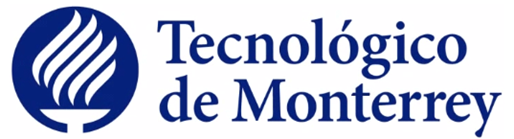

Maestría en Inteligencia Artificial Aplicada (MNA)
Curso: TC5035 Proyecto Integrador

Profesores: Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón

Proyecto: Reconocimiento y Clasificación de Objetos basado en Colores para Detección en Vivo en Cámaras de Seguridad
##Avance 5. Modelo Final

Equipo 43
* Ronald David Zuniga Sanchez - A01686240

#1 - Introducción

En el presente avance del Proyecto Integrador **Reconocimiento y Clasificación de Objetos basado en Colores para Detección en Vivo en Cámaras de Seguridad**, se desarrolla la optimización final del modelo seleccionado para maximizar su rendimiento evaluando la calidad de las predicciones y minimizando los recursos necesarios para las inferencias.

#2 - Importando el Dataset

In [108]:
import torch
import torch.nn as nn
import os
import  numpy as np
import pandas as pd
from torch.utils.data import  Dataset, DataLoader
from  PIL import  Image
from  torchvision.transforms import  ToTensor, Compose, Resize, CenterCrop
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import  glob
import requests

import requests
from zipfile import ZipFile
import shutil
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F

!pip install opencv-python-headless

from PIL import Image
import cv2
from collections import Counter

from  tqdm import tqdm
from sklearn.metrics import accuracy_score

from  collections import  defaultdict
import json

In [109]:
# URL of the .zip file in the GitHub repository
github_zip_url = "https://github.com/rzunick/MNA-Proyecto-Integrador-Equipo-43/raw/main/cifar_10_color_v4_balanced.zip?download="

# Path to save the downloaded .zip file
zip_file_path = '/content/cifar_10_color_v4.zip'

# Download the .zip file from GitHub
response = requests.get(github_zip_url)
with open(zip_file_path, 'wb') as f:
    f.write(response.content)

# Verify the download
if response.status_code == 200:
    print("File downloaded successfully")
else:
    print("Failed to download file")

File downloaded successfully


In [110]:
#Specify zip file path
zip_file_path = '/content/cifar_10_color_v4.zip'

In [111]:
# Confirmar tipo de archivo es tipo .zip
!file /content/cifar_10_color.zip

/content/cifar_10_color.zip: cannot open `/content/cifar_10_color.zip' (No such file or directory)


In [112]:
from zipfile import ZipFile

# Specify the directory where you want to extract the files
extract_to_directory = '/content'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)

In [113]:
# Dataset Path
path = '/content/cifar_10_color_v4'

Label counts: Counter({6: 1600, 1: 1600, 7: 1600, 5: 1600, 0: 1600, 4: 1600, 2: 1600, 3: 1600})


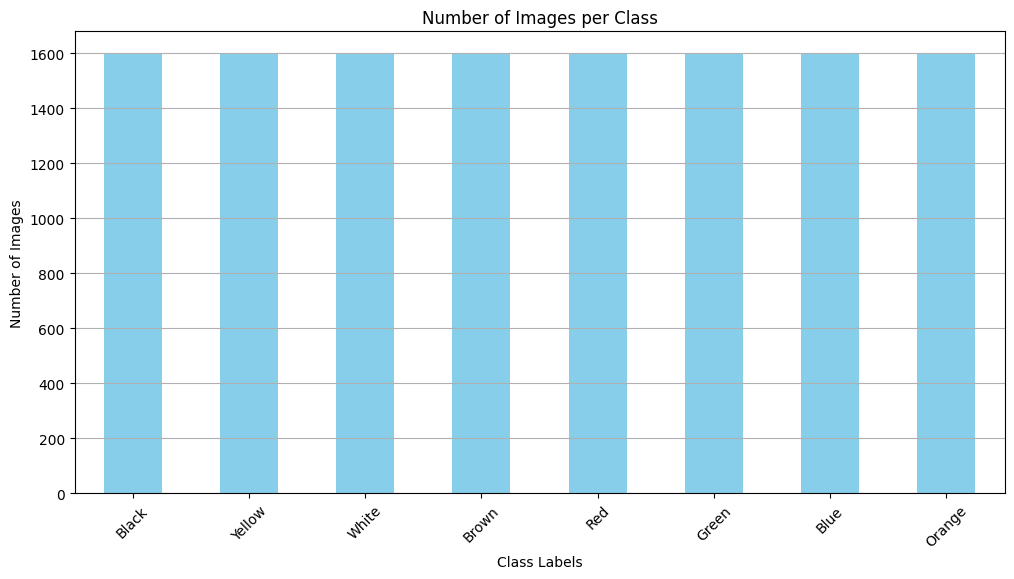

In [114]:
# Configuration 4: 8 labels
labels = ["Red","Yellow","Blue","Orange","Green","Brown","Black","White"]

def decode_label(index):
    return  labels[index]

def encode_label_from_path(path):
    for index,value in enumerate(labels):
        if value in path:
            return  index

# Get image list
image_list = glob.glob(os.path.join(path, '**', '*.*'), recursive=True)
class_list = [encode_label_from_path(item) for item in image_list]

# Count the number of images per class
from collections import Counter
label_counts = Counter(class_list)
print("Label counts:", label_counts)

# Convert the counter to a pandas DataFrame
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
label_df.index = [labels[idx] for idx in label_df.index]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
label_df['count'].plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.show()

In [115]:
from sklearn.model_selection import train_test_split
x_train, x_test , y_train , y_test = train_test_split(image_list, class_list, train_size= 0.6 , stratify=class_list , shuffle=True, random_state=42)

In [116]:
class ColorDataset_RGB(Dataset):
    def __init__(self, image_list, class_list, transforms = None):
        self.transform = transforms
        self.image_list = image_list
        self.class_list = class_list
        self.data_len = len(self.image_list)

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.class_list[index]

transforms=Compose([ToTensor()])

train_dataset_rgb = ColorDataset_RGB( x_train , y_train , transforms)
train_data_loader = DataLoader(train_dataset_rgb,batch_size=32)

test_dataset_rgb = ColorDataset_RGB(x_test, y_test,transforms)
test_data_loader = DataLoader(test_dataset_rgb, batch_size=32)

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


#3 - Exploración de Modelos Alternativos


## Modelo Base

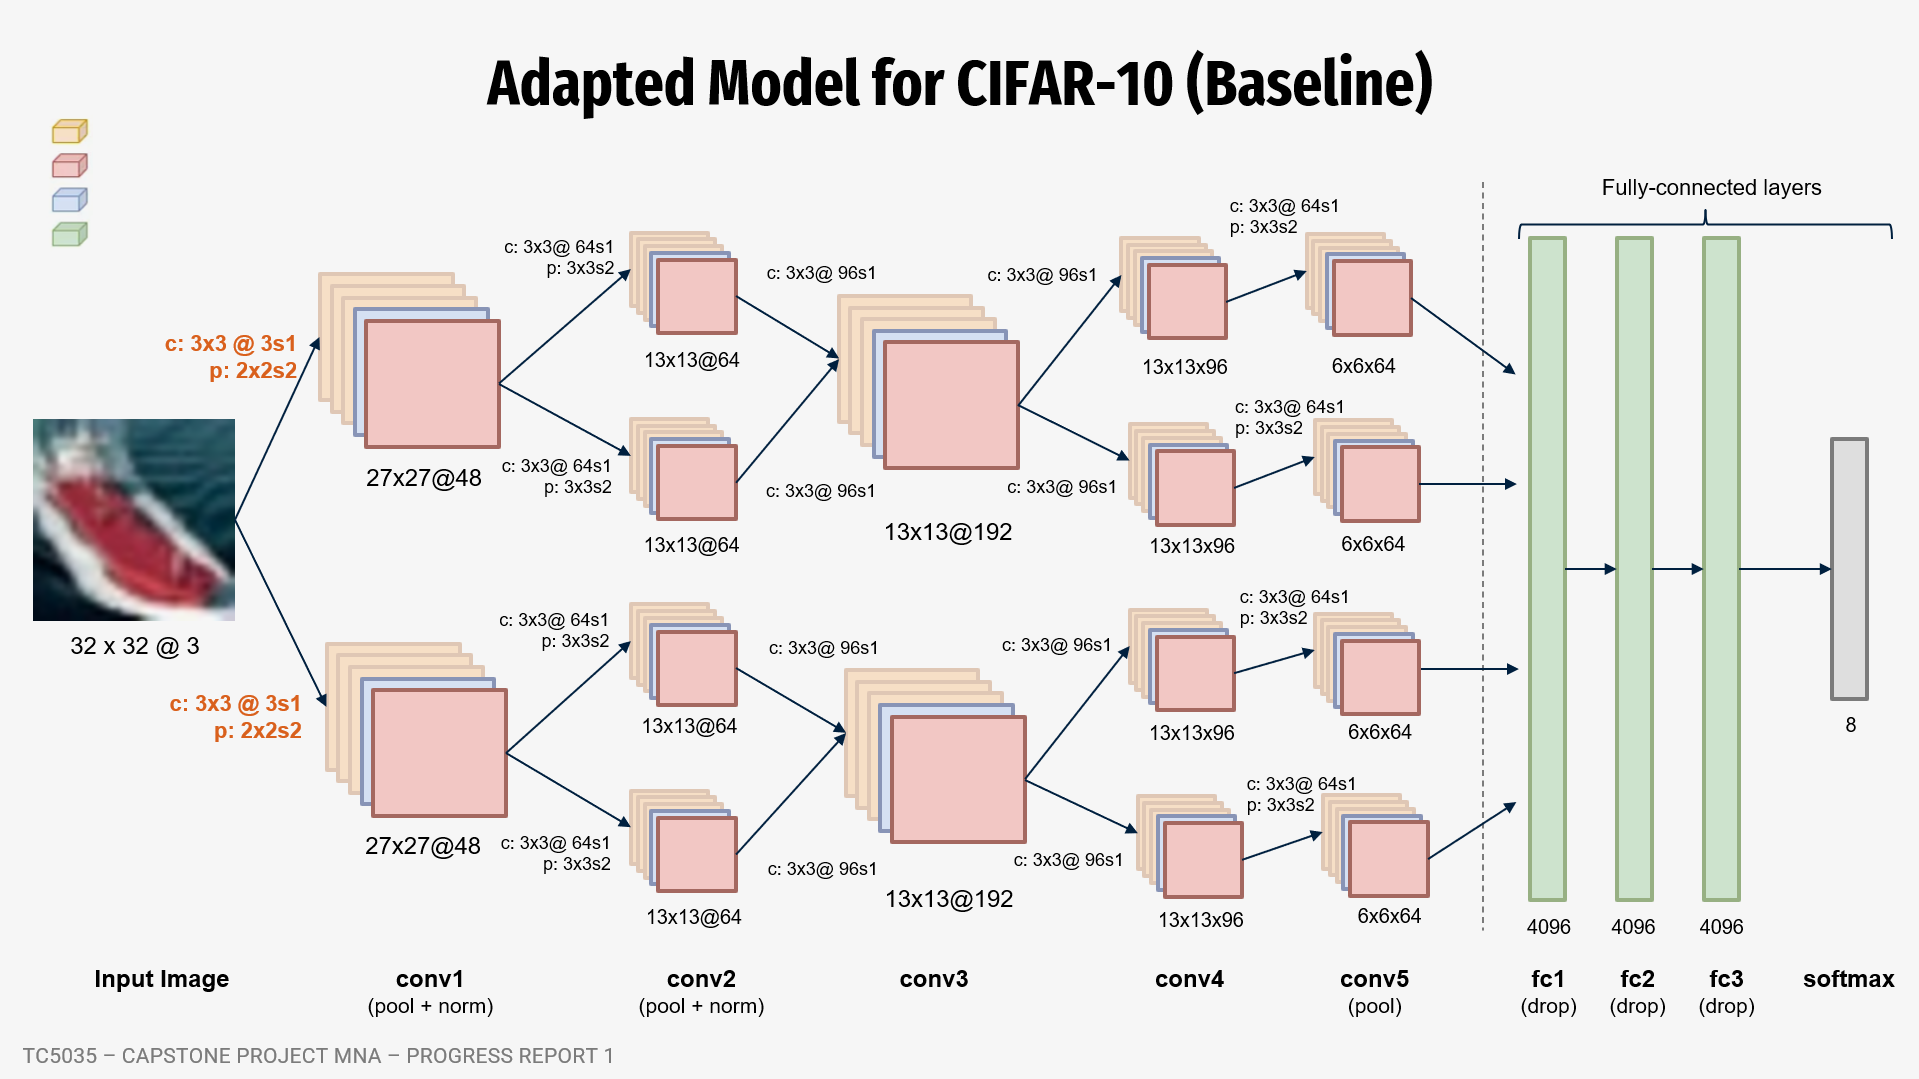

In [118]:
#Define Model
class ColorModel1(nn.Module):
    def __init__(self):
        super(ColorModel1, self).__init__()

        self.top_conv1 = nn.Sequential(
            nn.Conv2d(3,48, kernel_size=(3,3) , stride=(1,1)), # smaller kernel size and stride
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2 , stride=2) # smaller pooling size
        )

        # first top convolution layer    after split
        self.top_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.top_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.top_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.top_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.top_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.top_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.top_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

#        # ===============================  bottom ================================


#         # first bottom convolution layer
        self.bottom_conv1 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(3, 48, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        # first top convolution layer    after split
        self.bottom_top_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.bottom_bot_conv2 = nn.Sequential(

            # 1-1 conv layer
            nn.Conv2d(24, 64, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )


        #  need a concat

        # after concat
        self.bottom_conv3 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(128, 192, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        # fourth top convolution layer
        # split feature map by half
        self.bottom_top_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )

        self.bottom_bot_conv4 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 96, kernel_size=(3,3), stride=(1,1),padding=1),
            nn.ReLU()
        )


        # fifth top convolution layer
        self.bottom_top_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.bottom_bot_conv5 = nn.Sequential(
            # 1-1 conv layer
            nn.Conv2d(96, 64, kernel_size=(3,3), stride=(2,2),padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully-connected layer
        self.classifier = nn.Sequential(
            nn.Linear(1024, 4096), # Adjusted for output size
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(4096, 8)
        )

    def forward(self,x):

        # Top Path

        #print(x.shape)
        x_top = self.top_conv1(x)
        #print(x_top.shape)

        x_top_conv = torch.split(x_top, 24, 1)

        x_top_top_conv2 = self.top_top_conv2(x_top_conv[0])
        x_top_bot_conv2 = self.top_bot_conv2(x_top_conv[1])

        x_top_cat1 = torch.cat([x_top_top_conv2,x_top_bot_conv2],1)

        x_top_conv3 = self.top_conv3(x_top_cat1)

        x_top_conv3 = torch.split(x_top_conv3, 96, 1)

        x_top_top_conv4 = self.top_top_conv4(x_top_conv3[0])
        x_top_bot_conv4 = self.top_bot_conv4(x_top_conv3[1])

        x_top_top_conv5 = self.top_top_conv5(x_top_top_conv4)
        x_top_bot_conv5 = self.top_bot_conv5(x_top_bot_conv4)

        # Bottom Path
        x_bottom = self.bottom_conv1(x)

        x_bottom_conv = torch.split(x_bottom, 24, 1)

        x_bottom_top_conv2 = self.bottom_top_conv2(x_bottom_conv[0])
        x_bottom_bot_conv2 = self.bottom_bot_conv2(x_bottom_conv[1])

        x_bottom_cat1 = torch.cat([x_bottom_top_conv2,x_bottom_bot_conv2],1)

        x_bottom_conv3 = self.bottom_conv3(x_bottom_cat1)

        x_bottom_conv3 = torch.split(x_bottom_conv3, 96, 1)

        x_bottom_top_conv4 = self.bottom_top_conv4(x_bottom_conv3[0])
        x_bottom_bot_conv4 = self.bottom_bot_conv4(x_bottom_conv3[1])

        x_bottom_top_conv5 = self.bottom_top_conv5(x_bottom_top_conv4)
        x_bottom_bot_conv5 = self.bottom_bot_conv5(x_bottom_bot_conv4)

        # Concatenate
        x_cat = torch.cat([x_top_top_conv5,x_top_bot_conv5,x_bottom_top_conv5,x_bottom_bot_conv5],1)

        # Print shape before flattening
        #print("x_cat shape before flattening:", x_cat.shape)

        flatten = x_cat.view(x_cat.size(0), -1)
        #print("flatten shape:", flatten.shape)

        output = self.classifier(flatten)

        #output = F.softmax(output)


        return output

In [119]:
class Logger(object):
    def __init__(self, log_dir, name, chkpt_interval):
        super(Logger,self).__init__()
        self.chkpt_interval = chkpt_interval
        self.log_dir = log_dir
        self.name = name
        os.makedirs(os.path.join(log_dir, name), exist_ok= True)
        self.log_path = os.path.join(log_dir, name, 'logs.json')
        self.model_path = os.path.join(log_dir, name, 'model.pt')
        self.logs = defaultdict(list)
        self.logs['epoch'] = 0

    def log(self, key, value ):
        if isinstance(value, dict):
            for k,v in value.items():
                self.log(f'{key}.{k}',v)
        else:
            self.logs[key].append(value)

    def checkpoint(self, model):
        if (self.logs['epoch'] + 1 ) % self.chkpt_interval == 0:
            self.save(model)
        self.logs['epoch'] +=1

    def save(self, model):
        print("Saving Model...")
        with open(self.log_path, 'w') as f:
            json.dump(self.logs, f, sort_keys=True, indent=4)
        epch = self.logs['epoch'] + 1
        torch.save(model.state_dict(), os.path.join(self.log_dir, self.name, f'model_{epch}.pt'))

In [120]:
# Save Model
Model_Path = '/content/models/baseline_model_A'
logger = Logger(Model_Path, "Exp1A", 1)

In [121]:
model = ColorModel1()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [122]:
epochs = 20
for epoch in range(epochs):
    with tqdm(train_data_loader, unit="batch") as tepoch:
        model.train()
        running_loss = 0
        batch_ = 0
        for X,y in tepoch:
            tepoch.set_description(f"Train | Epoch {epoch}")
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model.forward(X)
            loss_value = loss_fn(pred, y)
            loss_value.backward()
            opt.step()
            opt.zero_grad()
            batch_ +=1
            running_loss += loss_value.item()
            tepoch.set_postfix(loss = running_loss/batch_)
        logger.log('train_loss', running_loss/batch_)
    with torch.no_grad():
        model.eval()
        with tqdm(test_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Test | Epoch {epoch}")
            correct = 0
            n_batch = 0
            running_loss = 0
            for X,y in tepoch:
                X, y = X.to('cuda') , y.to('cuda')
                pred = model.forward(X)
                pred_class = pred.argmax(dim = 1)
                loss_value = loss_fn(pred,y)
                running_loss += loss_value.item()
                curr_correct = (pred_class == y).float().sum().item()
                correct += curr_correct
                n_batch +=1
                tepoch.set_postfix(loss = running_loss/n_batch , accuracy = correct / (n_batch*32) *100)
            logger.log('test_loss', running_loss/n_batch)
            logger.log('test_acc', correct/(n_batch*32))
    logger.checkpoint(model)

Train | Epoch 0: 100%|██████████| 240/240 [00:06<00:00, 39.19batch/s, loss=2.08]
Test | Epoch 0: 100%|██████████| 160/160 [00:02<00:00, 63.51batch/s, accuracy=20.3, loss=2.06]


Saving Model...


Train | Epoch 1: 100%|██████████| 240/240 [00:05<00:00, 40.69batch/s, loss=2.02]
Test | Epoch 1: 100%|██████████| 160/160 [00:02<00:00, 64.47batch/s, accuracy=26, loss=1.95]


Saving Model...


Train | Epoch 2: 100%|██████████| 240/240 [00:06<00:00, 37.09batch/s, loss=1.87]
Test | Epoch 2: 100%|██████████| 160/160 [00:02<00:00, 61.42batch/s, accuracy=34.9, loss=1.77]


Saving Model...


Train | Epoch 3: 100%|██████████| 240/240 [00:05<00:00, 40.08batch/s, loss=1.72]
Test | Epoch 3: 100%|██████████| 160/160 [00:02<00:00, 66.01batch/s, accuracy=40.9, loss=1.6]


Saving Model...


Train | Epoch 4: 100%|██████████| 240/240 [00:05<00:00, 40.56batch/s, loss=1.56]
Test | Epoch 4: 100%|██████████| 160/160 [00:02<00:00, 62.88batch/s, accuracy=46, loss=1.51]


Saving Model...


Train | Epoch 5: 100%|██████████| 240/240 [00:06<00:00, 39.23batch/s, loss=1.46]
Test | Epoch 5: 100%|██████████| 160/160 [00:02<00:00, 65.76batch/s, accuracy=49.5, loss=1.41]


Saving Model...


Train | Epoch 6: 100%|██████████| 240/240 [00:06<00:00, 39.21batch/s, loss=1.39]
Test | Epoch 6: 100%|██████████| 160/160 [00:02<00:00, 65.10batch/s, accuracy=51.8, loss=1.36]


Saving Model...


Train | Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 40.35batch/s, loss=1.34]
Test | Epoch 7: 100%|██████████| 160/160 [00:02<00:00, 63.05batch/s, accuracy=53.2, loss=1.32]


Saving Model...


Train | Epoch 8: 100%|██████████| 240/240 [00:06<00:00, 39.65batch/s, loss=1.29]
Test | Epoch 8: 100%|██████████| 160/160 [00:02<00:00, 63.52batch/s, accuracy=55.5, loss=1.27]


Saving Model...


Train | Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 40.24batch/s, loss=1.25]
Test | Epoch 9: 100%|██████████| 160/160 [00:02<00:00, 66.38batch/s, accuracy=56, loss=1.25]


Saving Model...


Train | Epoch 10: 100%|██████████| 240/240 [00:05<00:00, 40.56batch/s, loss=1.19]
Test | Epoch 10: 100%|██████████| 160/160 [00:02<00:00, 65.31batch/s, accuracy=57.7, loss=1.2]


Saving Model...


Train | Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 40.34batch/s, loss=1.15]
Test | Epoch 11: 100%|██████████| 160/160 [00:02<00:00, 64.37batch/s, accuracy=58.8, loss=1.18]


Saving Model...


Train | Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 40.84batch/s, loss=1.11]
Test | Epoch 12: 100%|██████████| 160/160 [00:02<00:00, 66.00batch/s, accuracy=58, loss=1.2]


Saving Model...


Train | Epoch 13: 100%|██████████| 240/240 [00:05<00:00, 41.37batch/s, loss=1.07]
Test | Epoch 13: 100%|██████████| 160/160 [00:02<00:00, 65.23batch/s, accuracy=58.6, loss=1.16]


Saving Model...


Train | Epoch 14: 100%|██████████| 240/240 [00:05<00:00, 40.84batch/s, loss=1.03]
Test | Epoch 14: 100%|██████████| 160/160 [00:02<00:00, 65.74batch/s, accuracy=59.5, loss=1.15]


Saving Model...


Train | Epoch 15: 100%|██████████| 240/240 [00:05<00:00, 41.11batch/s, loss=1]
Test | Epoch 15: 100%|██████████| 160/160 [00:02<00:00, 64.93batch/s, accuracy=60.1, loss=1.15]


Saving Model...


Train | Epoch 16: 100%|██████████| 240/240 [00:06<00:00, 39.73batch/s, loss=0.967]
Test | Epoch 16: 100%|██████████| 160/160 [00:02<00:00, 65.66batch/s, accuracy=59.8, loss=1.16]


Saving Model...


Train | Epoch 17: 100%|██████████| 240/240 [00:06<00:00, 39.95batch/s, loss=0.943]
Test | Epoch 17: 100%|██████████| 160/160 [00:02<00:00, 64.99batch/s, accuracy=60.7, loss=1.15]


Saving Model...


Train | Epoch 18: 100%|██████████| 240/240 [00:06<00:00, 39.97batch/s, loss=0.91]
Test | Epoch 18: 100%|██████████| 160/160 [00:02<00:00, 64.71batch/s, accuracy=61.1, loss=1.16]


Saving Model...


Train | Epoch 19: 100%|██████████| 240/240 [00:06<00:00, 39.90batch/s, loss=0.871]
Test | Epoch 19: 100%|██████████| 160/160 [00:02<00:00, 64.06batch/s, accuracy=61, loss=1.17]


Saving Model...


Métricas

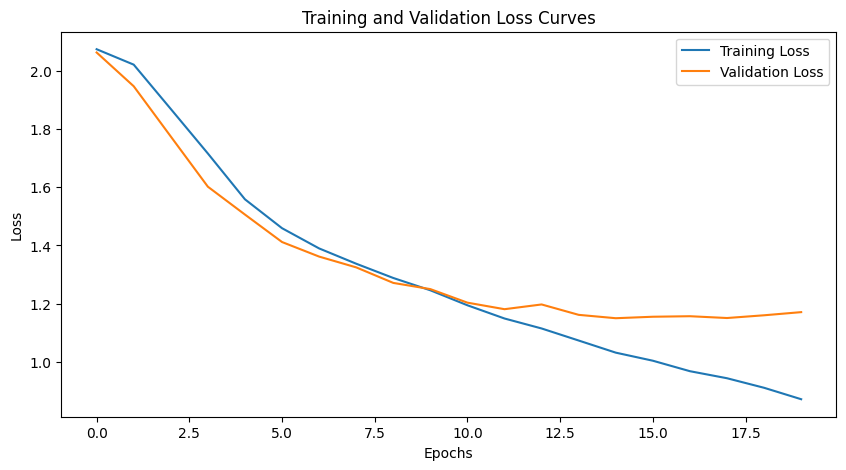

In [123]:

import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Example usage
train_losses = logger.logs['train_loss']
val_losses = logger.logs['test_loss']
plot_loss_curves(train_losses, val_losses)

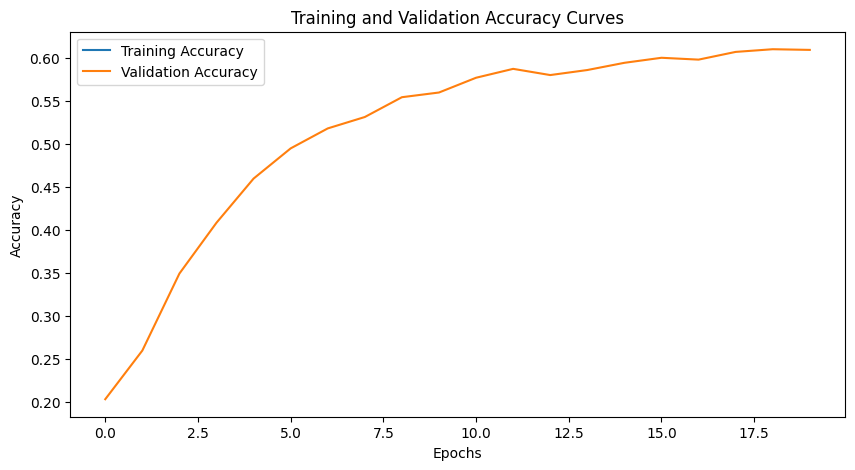

In [124]:

def plot_accuracy_curves(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Example usage
train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['test_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

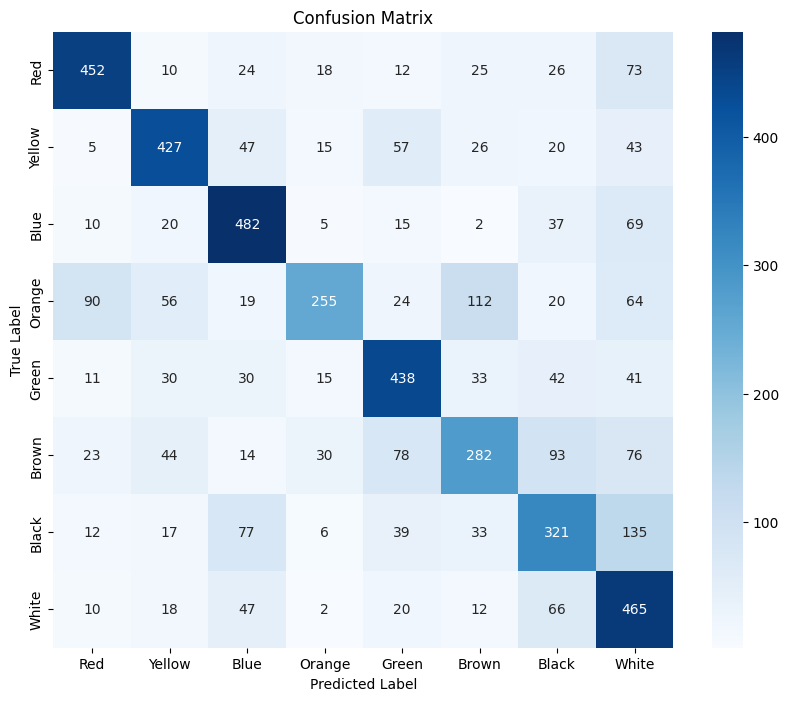

In [125]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure labels are defined
labels = ["Red", "Yellow", "Blue", "Orange", "Green", "Brown", "Black", "White"]

# Example usage (assuming y_test contains true labels)
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, labels)


## Modelo 2 - RGB

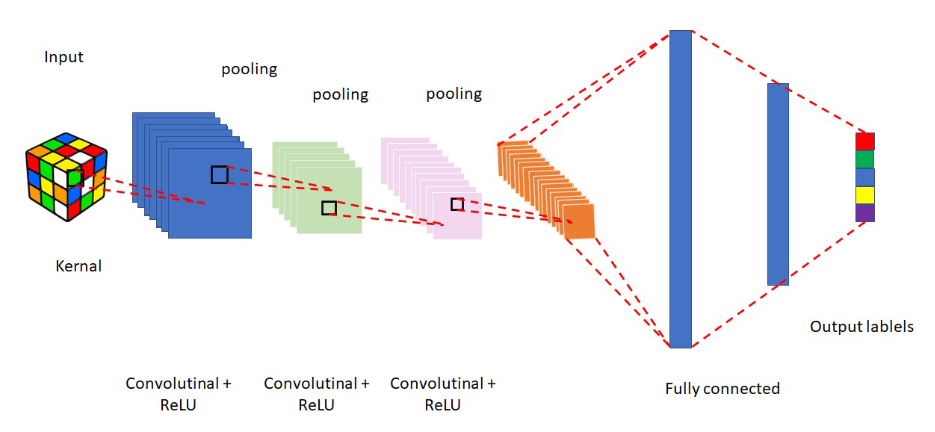

In [126]:
class ColorModel2(nn.Module):
    def __init__(self):
        super(ColorModel2, self).__init__()

        # Convolutional Layer 1: Input channels = 3 (RGB), Output channels = 32
        # Kernel size = 3x3, Padding = 1 (to maintain size)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling over a (2, 2) window

        # Convolutional Layer 2: Increasing the depth to 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Convolutional Layer 3: Increasing the depth to 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully Connected Layers
        # Flattening the output from the convolutional layers to feed into the fully connected layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Image size is 32x32 initially and reduced to 4x4 after three poolings
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)  # Output layer: 8 classes for colors

    def forward(self, x):
        # Applying convolution + ReLU + pooling in each convolution layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Correct flattening based on the output size of the last pooling layer
        x = x.view(-1, 128 * 4 * 4)  # ensure this matches the size, here 128 * 4 * 4 is based on the assumption the output is 4x4 at the last conv layer

        # Fully connected layers with ReLU activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer
        x = self.fc3(x)
        return x

In [127]:
# Save Model
Model_Path = '/content/models/alternative_model_A'
logger = Logger(Model_Path, "Exp1", 1)

In [128]:
model = ColorModel2()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [129]:
epochs = 100
from  tqdm import tqdm
from sklearn.metrics import accuracy_score
for epoch in range(epochs):
    with tqdm(train_data_loader, unit="batch") as tepoch:
        model.train()
        running_loss = 0
        batch_ = 0
        for X,y in tepoch:
            tepoch.set_description(f"Train | Epoch {epoch}")
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model.forward(X)
            loss_value = loss_fn(pred, y)
            loss_value.backward()
            opt.step()
            opt.zero_grad()
            batch_ +=1
            running_loss += loss_value.item()
            tepoch.set_postfix(loss = running_loss/batch_)
        logger.log('train_loss', running_loss/batch_)
    with torch.no_grad():
        model.eval()
        with tqdm(test_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Test | Epoch {epoch}")
            correct = 0
            n_batch = 0
            running_loss = 0
            for X,y in tepoch:
                X, y = X.to('cuda') , y.to('cuda')
                pred = model.forward(X)
                pred_class = pred.argmax(dim = 1)
                loss_value = loss_fn(pred,y)
                running_loss += loss_value.item()
                curr_correct = (pred_class == y).float().sum().item()
                correct += curr_correct
                n_batch +=1
                tepoch.set_postfix(loss = running_loss/n_batch , accuracy = correct / (n_batch*32) *100)
            logger.log('test_loss', running_loss/n_batch)
            logger.log('test_acc', correct/(n_batch*32))
    logger.checkpoint(model)

Train | Epoch 0: 100%|██████████| 240/240 [00:03<00:00, 61.05batch/s, loss=2.08]
Test | Epoch 0: 100%|██████████| 160/160 [00:02<00:00, 78.74batch/s, accuracy=12.6, loss=2.08]


Saving Model...


Train | Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 62.16batch/s, loss=2.08]
Test | Epoch 1: 100%|██████████| 160/160 [00:02<00:00, 77.43batch/s, accuracy=15.3, loss=2.08]


Saving Model...


Train | Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 63.18batch/s, loss=2.08]
Test | Epoch 2: 100%|██████████| 160/160 [00:02<00:00, 75.08batch/s, accuracy=13.4, loss=2.08]


Saving Model...


Train | Epoch 3: 100%|██████████| 240/240 [00:04<00:00, 59.86batch/s, loss=2.08]
Test | Epoch 3: 100%|██████████| 160/160 [00:02<00:00, 71.82batch/s, accuracy=13.1, loss=2.08]


Saving Model...


Train | Epoch 4: 100%|██████████| 240/240 [00:04<00:00, 59.84batch/s, loss=2.08]
Test | Epoch 4: 100%|██████████| 160/160 [00:02<00:00, 76.09batch/s, accuracy=13.7, loss=2.08]


Saving Model...


Train | Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 64.06batch/s, loss=2.08]
Test | Epoch 5: 100%|██████████| 160/160 [00:02<00:00, 79.65batch/s, accuracy=17, loss=2.08]


Saving Model...


Train | Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 64.96batch/s, loss=2.08]
Test | Epoch 6: 100%|██████████| 160/160 [00:02<00:00, 76.71batch/s, accuracy=22.1, loss=2.08]


Saving Model...


Train | Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 61.68batch/s, loss=2.08]
Test | Epoch 7: 100%|██████████| 160/160 [00:02<00:00, 79.95batch/s, accuracy=23.8, loss=2.08]


Saving Model...


Train | Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 64.93batch/s, loss=2.08]
Test | Epoch 8: 100%|██████████| 160/160 [00:02<00:00, 78.00batch/s, accuracy=23.1, loss=2.07]


Saving Model...


Train | Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 62.47batch/s, loss=2.07]
Test | Epoch 9: 100%|██████████| 160/160 [00:02<00:00, 78.37batch/s, accuracy=22.4, loss=2.07]


Saving Model...


Train | Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 63.37batch/s, loss=2.07]
Test | Epoch 10: 100%|██████████| 160/160 [00:02<00:00, 79.04batch/s, accuracy=22.1, loss=2.07]


Saving Model...


Train | Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 61.14batch/s, loss=2.06]
Test | Epoch 11: 100%|██████████| 160/160 [00:02<00:00, 78.34batch/s, accuracy=23, loss=2.06]


Saving Model...


Train | Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 62.17batch/s, loss=2.04]
Test | Epoch 12: 100%|██████████| 160/160 [00:02<00:00, 77.52batch/s, accuracy=23.2, loss=2.02]


Saving Model...


Train | Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 62.94batch/s, loss=1.98]
Test | Epoch 13: 100%|██████████| 160/160 [00:02<00:00, 79.18batch/s, accuracy=23.7, loss=1.94]


Saving Model...


Train | Epoch 14: 100%|██████████| 240/240 [00:04<00:00, 59.98batch/s, loss=1.9]
Test | Epoch 14: 100%|██████████| 160/160 [00:02<00:00, 76.52batch/s, accuracy=29.1, loss=1.86]


Saving Model...


Train | Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 64.31batch/s, loss=1.83]
Test | Epoch 15: 100%|██████████| 160/160 [00:02<00:00, 77.97batch/s, accuracy=30.8, loss=1.81]


Saving Model...


Train | Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 60.83batch/s, loss=1.77]
Test | Epoch 16: 100%|██████████| 160/160 [00:02<00:00, 76.61batch/s, accuracy=32.8, loss=1.76]


Saving Model...


Train | Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 64.14batch/s, loss=1.73]
Test | Epoch 17: 100%|██████████| 160/160 [00:02<00:00, 79.50batch/s, accuracy=34.3, loss=1.73]


Saving Model...


Train | Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 62.92batch/s, loss=1.69]
Test | Epoch 18: 100%|██████████| 160/160 [00:02<00:00, 77.47batch/s, accuracy=35.6, loss=1.7]


Saving Model...


Train | Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 64.29batch/s, loss=1.67]
Test | Epoch 19: 100%|██████████| 160/160 [00:02<00:00, 79.72batch/s, accuracy=36, loss=1.69]


Saving Model...


Train | Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 63.36batch/s, loss=1.65]
Test | Epoch 20: 100%|██████████| 160/160 [00:02<00:00, 75.46batch/s, accuracy=36, loss=1.69]


Saving Model...


Train | Epoch 21: 100%|██████████| 240/240 [00:03<00:00, 64.46batch/s, loss=1.63]
Test | Epoch 21: 100%|██████████| 160/160 [00:01<00:00, 80.11batch/s, accuracy=36.4, loss=1.68]


Saving Model...


Train | Epoch 22: 100%|██████████| 240/240 [00:03<00:00, 64.44batch/s, loss=1.61]
Test | Epoch 22: 100%|██████████| 160/160 [00:02<00:00, 78.11batch/s, accuracy=37.2, loss=1.67]


Saving Model...


Train | Epoch 23: 100%|██████████| 240/240 [00:03<00:00, 64.18batch/s, loss=1.6]
Test | Epoch 23: 100%|██████████| 160/160 [00:02<00:00, 78.60batch/s, accuracy=38, loss=1.65]


Saving Model...


Train | Epoch 24: 100%|██████████| 240/240 [00:03<00:00, 63.46batch/s, loss=1.58]
Test | Epoch 24: 100%|██████████| 160/160 [00:02<00:00, 78.12batch/s, accuracy=38.8, loss=1.64]


Saving Model...


Train | Epoch 25: 100%|██████████| 240/240 [00:03<00:00, 64.47batch/s, loss=1.56]
Test | Epoch 25: 100%|██████████| 160/160 [00:02<00:00, 78.18batch/s, accuracy=39.1, loss=1.62]


Saving Model...


Train | Epoch 26: 100%|██████████| 240/240 [00:03<00:00, 64.01batch/s, loss=1.55]
Test | Epoch 26: 100%|██████████| 160/160 [00:02<00:00, 76.96batch/s, accuracy=40, loss=1.6]


Saving Model...


Train | Epoch 27: 100%|██████████| 240/240 [00:03<00:00, 64.23batch/s, loss=1.52]
Test | Epoch 27: 100%|██████████| 160/160 [00:02<00:00, 78.67batch/s, accuracy=40.4, loss=1.58]


Saving Model...


Train | Epoch 28: 100%|██████████| 240/240 [00:03<00:00, 63.75batch/s, loss=1.5]
Test | Epoch 28: 100%|██████████| 160/160 [00:02<00:00, 75.70batch/s, accuracy=42.6, loss=1.55]


Saving Model...


Train | Epoch 29: 100%|██████████| 240/240 [00:03<00:00, 63.06batch/s, loss=1.46]
Test | Epoch 29: 100%|██████████| 160/160 [00:02<00:00, 79.73batch/s, accuracy=44.7, loss=1.51]


Saving Model...


Train | Epoch 30: 100%|██████████| 240/240 [00:03<00:00, 63.10batch/s, loss=1.42]
Test | Epoch 30: 100%|██████████| 160/160 [00:02<00:00, 75.67batch/s, accuracy=45.6, loss=1.5]


Saving Model...


Train | Epoch 31: 100%|██████████| 240/240 [00:03<00:00, 63.31batch/s, loss=1.39]
Test | Epoch 31: 100%|██████████| 160/160 [00:02<00:00, 79.99batch/s, accuracy=46.5, loss=1.49]


Saving Model...


Train | Epoch 32: 100%|██████████| 240/240 [00:03<00:00, 64.05batch/s, loss=1.36]
Test | Epoch 32: 100%|██████████| 160/160 [00:02<00:00, 76.95batch/s, accuracy=48.4, loss=1.44]


Saving Model...


Train | Epoch 33: 100%|██████████| 240/240 [00:03<00:00, 63.23batch/s, loss=1.33]
Test | Epoch 33: 100%|██████████| 160/160 [00:02<00:00, 77.70batch/s, accuracy=49.9, loss=1.39]


Saving Model...


Train | Epoch 34: 100%|██████████| 240/240 [00:03<00:00, 63.89batch/s, loss=1.3]
Test | Epoch 34: 100%|██████████| 160/160 [00:02<00:00, 75.96batch/s, accuracy=50.9, loss=1.35]


Saving Model...


Train | Epoch 35: 100%|██████████| 240/240 [00:03<00:00, 63.14batch/s, loss=1.28]
Test | Epoch 35: 100%|██████████| 160/160 [00:02<00:00, 77.92batch/s, accuracy=51.4, loss=1.33]


Saving Model...


Train | Epoch 36: 100%|██████████| 240/240 [00:03<00:00, 63.12batch/s, loss=1.26]
Test | Epoch 36: 100%|██████████| 160/160 [00:02<00:00, 77.15batch/s, accuracy=52.9, loss=1.31]


Saving Model...


Train | Epoch 37: 100%|██████████| 240/240 [00:03<00:00, 63.46batch/s, loss=1.24]
Test | Epoch 37: 100%|██████████| 160/160 [00:02<00:00, 79.18batch/s, accuracy=53.6, loss=1.3]


Saving Model...


Train | Epoch 38: 100%|██████████| 240/240 [00:03<00:00, 64.89batch/s, loss=1.22]
Test | Epoch 38: 100%|██████████| 160/160 [00:02<00:00, 77.19batch/s, accuracy=54.1, loss=1.29]


Saving Model...


Train | Epoch 39: 100%|██████████| 240/240 [00:03<00:00, 63.50batch/s, loss=1.21]
Test | Epoch 39: 100%|██████████| 160/160 [00:02<00:00, 78.36batch/s, accuracy=54.5, loss=1.28]


Saving Model...


Train | Epoch 40: 100%|██████████| 240/240 [00:03<00:00, 64.64batch/s, loss=1.19]
Test | Epoch 40: 100%|██████████| 160/160 [00:02<00:00, 78.09batch/s, accuracy=55, loss=1.27]


Saving Model...


Train | Epoch 41: 100%|██████████| 240/240 [00:03<00:00, 63.56batch/s, loss=1.18]
Test | Epoch 41: 100%|██████████| 160/160 [00:02<00:00, 78.92batch/s, accuracy=55.3, loss=1.26]


Saving Model...


Train | Epoch 42: 100%|██████████| 240/240 [00:03<00:00, 62.96batch/s, loss=1.17]
Test | Epoch 42: 100%|██████████| 160/160 [00:02<00:00, 76.88batch/s, accuracy=55.7, loss=1.26]


Saving Model...


Train | Epoch 43: 100%|██████████| 240/240 [00:03<00:00, 63.46batch/s, loss=1.16]
Test | Epoch 43: 100%|██████████| 160/160 [00:02<00:00, 77.43batch/s, accuracy=55.8, loss=1.25]


Saving Model...


Train | Epoch 44: 100%|██████████| 240/240 [00:03<00:00, 63.82batch/s, loss=1.15]
Test | Epoch 44: 100%|██████████| 160/160 [00:02<00:00, 77.71batch/s, accuracy=55.8, loss=1.25]


Saving Model...


Train | Epoch 45: 100%|██████████| 240/240 [00:03<00:00, 64.69batch/s, loss=1.13]
Test | Epoch 45: 100%|██████████| 160/160 [00:02<00:00, 77.80batch/s, accuracy=56.3, loss=1.24]


Saving Model...


Train | Epoch 46: 100%|██████████| 240/240 [00:03<00:00, 62.81batch/s, loss=1.12]
Test | Epoch 46: 100%|██████████| 160/160 [00:02<00:00, 77.89batch/s, accuracy=56.3, loss=1.24]


Saving Model...


Train | Epoch 47: 100%|██████████| 240/240 [00:03<00:00, 62.64batch/s, loss=1.11]
Test | Epoch 47: 100%|██████████| 160/160 [00:02<00:00, 76.94batch/s, accuracy=56.4, loss=1.23]


Saving Model...


Train | Epoch 48: 100%|██████████| 240/240 [00:03<00:00, 63.13batch/s, loss=1.1]
Test | Epoch 48: 100%|██████████| 160/160 [00:02<00:00, 77.78batch/s, accuracy=57, loss=1.22]


Saving Model...


Train | Epoch 49: 100%|██████████| 240/240 [00:03<00:00, 62.83batch/s, loss=1.09]
Test | Epoch 49: 100%|██████████| 160/160 [00:02<00:00, 78.18batch/s, accuracy=57, loss=1.22]


Saving Model...


Train | Epoch 50: 100%|██████████| 240/240 [00:03<00:00, 62.43batch/s, loss=1.07]
Test | Epoch 50: 100%|██████████| 160/160 [00:02<00:00, 77.19batch/s, accuracy=57.3, loss=1.21]


Saving Model...


Train | Epoch 51: 100%|██████████| 240/240 [00:03<00:00, 63.88batch/s, loss=1.06]
Test | Epoch 51: 100%|██████████| 160/160 [00:02<00:00, 78.14batch/s, accuracy=57.7, loss=1.21]


Saving Model...


Train | Epoch 52: 100%|██████████| 240/240 [00:03<00:00, 63.59batch/s, loss=1.05]
Test | Epoch 52: 100%|██████████| 160/160 [00:02<00:00, 78.32batch/s, accuracy=57.8, loss=1.2]


Saving Model...


Train | Epoch 53: 100%|██████████| 240/240 [00:03<00:00, 64.12batch/s, loss=1.04]
Test | Epoch 53: 100%|██████████| 160/160 [00:02<00:00, 77.47batch/s, accuracy=57.9, loss=1.2]


Saving Model...


Train | Epoch 54: 100%|██████████| 240/240 [00:03<00:00, 64.29batch/s, loss=1.03]
Test | Epoch 54: 100%|██████████| 160/160 [00:02<00:00, 78.15batch/s, accuracy=58.1, loss=1.2]


Saving Model...


Train | Epoch 55: 100%|██████████| 240/240 [00:03<00:00, 63.80batch/s, loss=1.02]
Test | Epoch 55: 100%|██████████| 160/160 [00:02<00:00, 77.46batch/s, accuracy=58.2, loss=1.2]


Saving Model...


Train | Epoch 56: 100%|██████████| 240/240 [00:03<00:00, 64.39batch/s, loss=1]
Test | Epoch 56: 100%|██████████| 160/160 [00:02<00:00, 78.36batch/s, accuracy=58.5, loss=1.2]


Saving Model...


Train | Epoch 57: 100%|██████████| 240/240 [00:03<00:00, 64.59batch/s, loss=0.993]
Test | Epoch 57: 100%|██████████| 160/160 [00:02<00:00, 78.84batch/s, accuracy=58.8, loss=1.2]


Saving Model...


Train | Epoch 58: 100%|██████████| 240/240 [00:03<00:00, 62.99batch/s, loss=0.981]
Test | Epoch 58: 100%|██████████| 160/160 [00:02<00:00, 76.50batch/s, accuracy=58.8, loss=1.2]


Saving Model...


Train | Epoch 59: 100%|██████████| 240/240 [00:03<00:00, 63.71batch/s, loss=0.969]
Test | Epoch 59: 100%|██████████| 160/160 [00:02<00:00, 76.84batch/s, accuracy=58.7, loss=1.2]


Saving Model...


Train | Epoch 60: 100%|██████████| 240/240 [00:03<00:00, 62.94batch/s, loss=0.956]
Test | Epoch 60: 100%|██████████| 160/160 [00:02<00:00, 78.43batch/s, accuracy=58.8, loss=1.2]


Saving Model...


Train | Epoch 61: 100%|██████████| 240/240 [00:03<00:00, 63.77batch/s, loss=0.944]
Test | Epoch 61: 100%|██████████| 160/160 [00:02<00:00, 79.93batch/s, accuracy=59, loss=1.2]


Saving Model...


Train | Epoch 62: 100%|██████████| 240/240 [00:03<00:00, 62.92batch/s, loss=0.931]
Test | Epoch 62: 100%|██████████| 160/160 [00:02<00:00, 76.65batch/s, accuracy=59, loss=1.2]


Saving Model...


Train | Epoch 63: 100%|██████████| 240/240 [00:03<00:00, 63.70batch/s, loss=0.918]
Test | Epoch 63: 100%|██████████| 160/160 [00:02<00:00, 78.73batch/s, accuracy=59.1, loss=1.2]


Saving Model...


Train | Epoch 64: 100%|██████████| 240/240 [00:03<00:00, 62.42batch/s, loss=0.904]
Test | Epoch 64: 100%|██████████| 160/160 [00:02<00:00, 76.79batch/s, accuracy=59.3, loss=1.2]


Saving Model...


Train | Epoch 65: 100%|██████████| 240/240 [00:03<00:00, 63.13batch/s, loss=0.89]
Test | Epoch 65: 100%|██████████| 160/160 [00:02<00:00, 79.08batch/s, accuracy=59.3, loss=1.21]


Saving Model...


Train | Epoch 66: 100%|██████████| 240/240 [00:03<00:00, 62.07batch/s, loss=0.875]
Test | Epoch 66: 100%|██████████| 160/160 [00:02<00:00, 77.49batch/s, accuracy=59.6, loss=1.21]


Saving Model...


Train | Epoch 67: 100%|██████████| 240/240 [00:03<00:00, 63.41batch/s, loss=0.861]
Test | Epoch 67: 100%|██████████| 160/160 [00:02<00:00, 78.78batch/s, accuracy=59.5, loss=1.21]


Saving Model...


Train | Epoch 68: 100%|██████████| 240/240 [00:03<00:00, 62.88batch/s, loss=0.845]
Test | Epoch 68: 100%|██████████| 160/160 [00:02<00:00, 77.69batch/s, accuracy=59.6, loss=1.22]


Saving Model...


Train | Epoch 69: 100%|██████████| 240/240 [00:03<00:00, 63.61batch/s, loss=0.828]
Test | Epoch 69: 100%|██████████| 160/160 [00:02<00:00, 78.64batch/s, accuracy=59.5, loss=1.22]


Saving Model...


Train | Epoch 70: 100%|██████████| 240/240 [00:03<00:00, 63.37batch/s, loss=0.811]
Test | Epoch 70: 100%|██████████| 160/160 [00:02<00:00, 77.90batch/s, accuracy=58.9, loss=1.23]


Saving Model...


Train | Epoch 71: 100%|██████████| 240/240 [00:03<00:00, 64.30batch/s, loss=0.794]
Test | Epoch 71: 100%|██████████| 160/160 [00:02<00:00, 79.44batch/s, accuracy=59, loss=1.24]


Saving Model...


Train | Epoch 72: 100%|██████████| 240/240 [00:03<00:00, 62.40batch/s, loss=0.776]
Test | Epoch 72: 100%|██████████| 160/160 [00:02<00:00, 76.87batch/s, accuracy=58.8, loss=1.25]


Saving Model...


Train | Epoch 73: 100%|██████████| 240/240 [00:03<00:00, 63.58batch/s, loss=0.757]
Test | Epoch 73: 100%|██████████| 160/160 [00:02<00:00, 77.96batch/s, accuracy=58.8, loss=1.26]


Saving Model...


Train | Epoch 74: 100%|██████████| 240/240 [00:03<00:00, 63.29batch/s, loss=0.737]
Test | Epoch 74: 100%|██████████| 160/160 [00:02<00:00, 78.09batch/s, accuracy=58.8, loss=1.27]


Saving Model...


Train | Epoch 75: 100%|██████████| 240/240 [00:03<00:00, 63.68batch/s, loss=0.716]
Test | Epoch 75: 100%|██████████| 160/160 [00:02<00:00, 76.62batch/s, accuracy=58.8, loss=1.29]


Saving Model...


Train | Epoch 76: 100%|██████████| 240/240 [00:03<00:00, 63.15batch/s, loss=0.696]
Test | Epoch 76: 100%|██████████| 160/160 [00:02<00:00, 77.46batch/s, accuracy=58.6, loss=1.3]


Saving Model...


Train | Epoch 77: 100%|██████████| 240/240 [00:03<00:00, 63.93batch/s, loss=0.673]
Test | Epoch 77: 100%|██████████| 160/160 [00:02<00:00, 77.50batch/s, accuracy=58.4, loss=1.32]


Saving Model...


Train | Epoch 78: 100%|██████████| 240/240 [00:03<00:00, 62.55batch/s, loss=0.652]
Test | Epoch 78: 100%|██████████| 160/160 [00:02<00:00, 79.16batch/s, accuracy=57.8, loss=1.35]


Saving Model...


Train | Epoch 79: 100%|██████████| 240/240 [00:03<00:00, 64.60batch/s, loss=0.63]
Test | Epoch 79: 100%|██████████| 160/160 [00:02<00:00, 78.35batch/s, accuracy=57.6, loss=1.37]


Saving Model...


Train | Epoch 80: 100%|██████████| 240/240 [00:03<00:00, 61.44batch/s, loss=0.606]
Test | Epoch 80: 100%|██████████| 160/160 [00:02<00:00, 76.78batch/s, accuracy=57.7, loss=1.39]


Saving Model...


Train | Epoch 81: 100%|██████████| 240/240 [00:03<00:00, 63.72batch/s, loss=0.582]
Test | Epoch 81: 100%|██████████| 160/160 [00:02<00:00, 77.13batch/s, accuracy=56.9, loss=1.43]


Saving Model...


Train | Epoch 82: 100%|██████████| 240/240 [00:03<00:00, 61.47batch/s, loss=0.558]
Test | Epoch 82: 100%|██████████| 160/160 [00:02<00:00, 77.55batch/s, accuracy=56.6, loss=1.47]


Saving Model...


Train | Epoch 83: 100%|██████████| 240/240 [00:03<00:00, 63.14batch/s, loss=0.536]
Test | Epoch 83: 100%|██████████| 160/160 [00:02<00:00, 77.20batch/s, accuracy=56.3, loss=1.51]


Saving Model...


Train | Epoch 84: 100%|██████████| 240/240 [00:03<00:00, 61.86batch/s, loss=0.512]
Test | Epoch 84: 100%|██████████| 160/160 [00:02<00:00, 77.78batch/s, accuracy=56.2, loss=1.53]


Saving Model...


Train | Epoch 85: 100%|██████████| 240/240 [00:03<00:00, 63.04batch/s, loss=0.488]
Test | Epoch 85: 100%|██████████| 160/160 [00:02<00:00, 79.28batch/s, accuracy=56.1, loss=1.57]


Saving Model...


Train | Epoch 86: 100%|██████████| 240/240 [00:03<00:00, 61.65batch/s, loss=0.469]
Test | Epoch 86: 100%|██████████| 160/160 [00:02<00:00, 75.48batch/s, accuracy=56, loss=1.61]


Saving Model...


Train | Epoch 87: 100%|██████████| 240/240 [00:03<00:00, 63.54batch/s, loss=0.451]
Test | Epoch 87: 100%|██████████| 160/160 [00:02<00:00, 79.52batch/s, accuracy=55.7, loss=1.66]


Saving Model...


Train | Epoch 88: 100%|██████████| 240/240 [00:03<00:00, 63.08batch/s, loss=0.446]
Test | Epoch 88: 100%|██████████| 160/160 [00:02<00:00, 76.95batch/s, accuracy=55.6, loss=1.72]


Saving Model...


Train | Epoch 89: 100%|██████████| 240/240 [00:03<00:00, 62.00batch/s, loss=0.436]
Test | Epoch 89: 100%|██████████| 160/160 [00:02<00:00, 78.39batch/s, accuracy=55, loss=1.8]


Saving Model...


Train | Epoch 90: 100%|██████████| 240/240 [00:03<00:00, 61.96batch/s, loss=0.445]
Test | Epoch 90: 100%|██████████| 160/160 [00:02<00:00, 78.43batch/s, accuracy=54.5, loss=1.86]


Saving Model...


Train | Epoch 91: 100%|██████████| 240/240 [00:03<00:00, 63.41batch/s, loss=0.499]
Test | Epoch 91: 100%|██████████| 160/160 [00:02<00:00, 78.87batch/s, accuracy=52.1, loss=1.93]


Saving Model...


Train | Epoch 92: 100%|██████████| 240/240 [00:03<00:00, 63.09batch/s, loss=0.524]
Test | Epoch 92: 100%|██████████| 160/160 [00:02<00:00, 78.72batch/s, accuracy=54.4, loss=1.8]


Saving Model...


Train | Epoch 93: 100%|██████████| 240/240 [00:03<00:00, 63.35batch/s, loss=0.466]
Test | Epoch 93: 100%|██████████| 160/160 [00:02<00:00, 77.22batch/s, accuracy=54.3, loss=1.84]


Saving Model...


Train | Epoch 94: 100%|██████████| 240/240 [00:03<00:00, 62.55batch/s, loss=0.434]
Test | Epoch 94: 100%|██████████| 160/160 [00:02<00:00, 77.29batch/s, accuracy=53.7, loss=1.86]


Saving Model...


Train | Epoch 95: 100%|██████████| 240/240 [00:03<00:00, 62.72batch/s, loss=0.409]
Test | Epoch 95: 100%|██████████| 160/160 [00:02<00:00, 77.50batch/s, accuracy=54.9, loss=1.78]


Saving Model...


Train | Epoch 96: 100%|██████████| 240/240 [00:03<00:00, 62.37batch/s, loss=0.374]
Test | Epoch 96: 100%|██████████| 160/160 [00:02<00:00, 78.34batch/s, accuracy=56.4, loss=1.77]


Saving Model...


Train | Epoch 97: 100%|██████████| 240/240 [00:03<00:00, 61.60batch/s, loss=0.333]
Test | Epoch 97: 100%|██████████| 160/160 [00:02<00:00, 72.31batch/s, accuracy=55.7, loss=1.89]


Saving Model...


Train | Epoch 98: 100%|██████████| 240/240 [00:04<00:00, 57.31batch/s, loss=0.31]
Test | Epoch 98: 100%|██████████| 160/160 [00:02<00:00, 75.92batch/s, accuracy=54.6, loss=2]


Saving Model...


Train | Epoch 99: 100%|██████████| 240/240 [00:03<00:00, 60.33batch/s, loss=0.299]
Test | Epoch 99: 100%|██████████| 160/160 [00:02<00:00, 76.73batch/s, accuracy=52.9, loss=2.21]


Saving Model...


Métricas

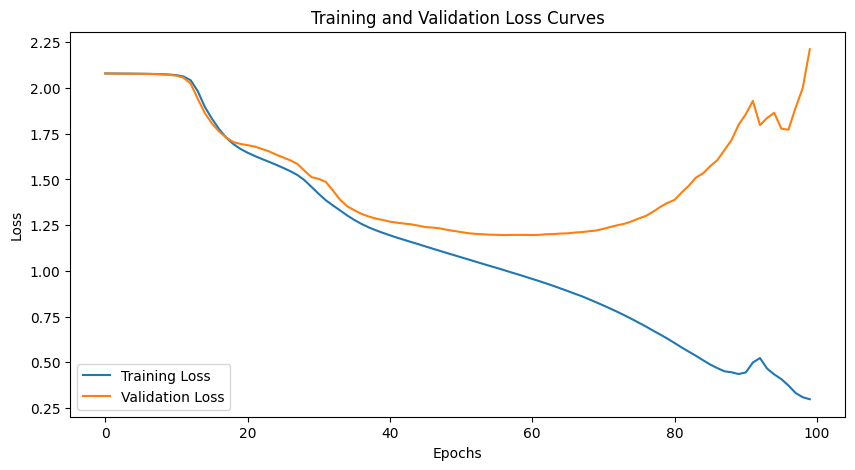

In [130]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Example usage
train_losses = logger.logs['train_loss']
val_losses = logger.logs['test_loss']
plot_loss_curves(train_losses, val_losses)

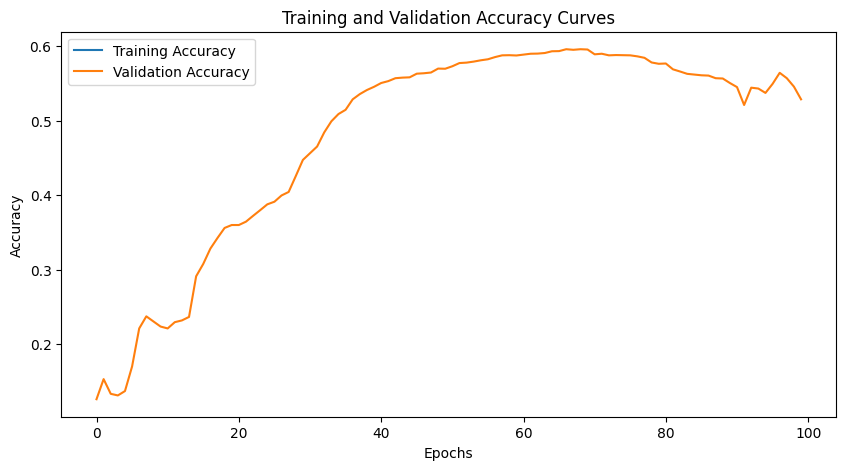

In [131]:
def plot_accuracy_curves(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Example usage
train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['test_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

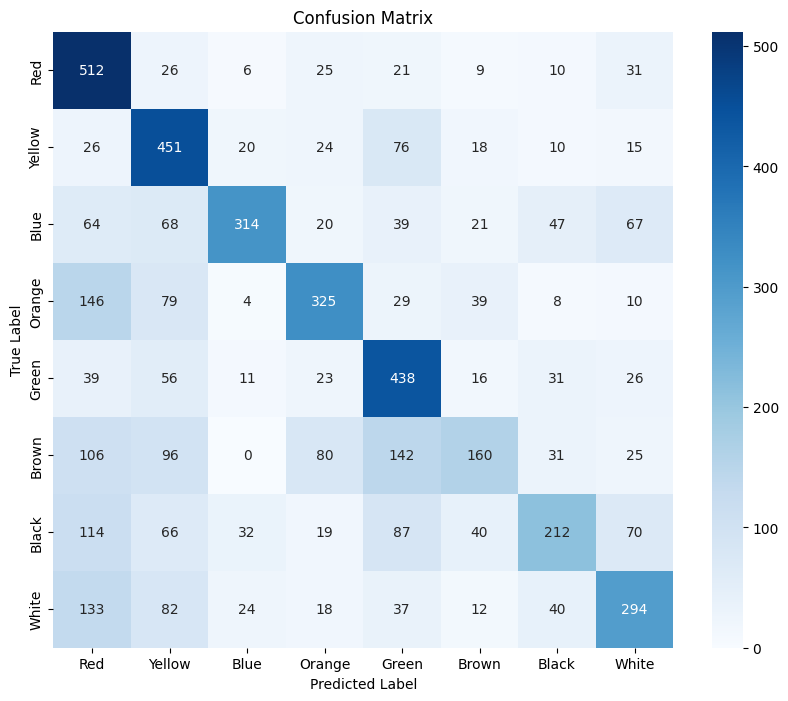

In [132]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure labels are defined
labels = ["Red", "Yellow", "Blue", "Orange", "Green", "Brown", "Black", "White"]

# Example usage (assuming y_test contains true labels)
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, labels)

## Modelo Base - CIELAB

In [133]:
# Dataset and DataLoader with CIELAB transformation
class ColorDataset_CIELAB(Dataset):
    def __init__(self, image_list, class_list, transforms=None):
        self.image_list = image_list
        self.class_list = class_list
        self.transforms = transforms

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        # Load image
        image_path = self.image_list[index]
        image = Image.open(image_path).convert('RGB')

        # Convert image to CIELAB
        image = np.array(image)
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        image_lab = Image.fromarray(image_lab)

        # Apply transformations if any
        if self.transforms:
            image_lab = self.transforms(image_lab)

        return image_lab, self.class_list[index]

train_dataset_lab = ColorDataset_CIELAB(image_list, class_list, transforms)
train_loader = DataLoader(train_dataset_lab, batch_size=32, shuffle=True)

In [134]:
# Save Model
Model_Path = '/content/models/baseline_model_B'
logger = Logger(Model_Path, "Exp1B", 1)

In [135]:
model = ColorModel1()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [136]:
epochs = 20
for epoch in range(epochs):
    with tqdm(train_data_loader, unit="batch") as tepoch:
        model.train()
        running_loss = 0
        batch_ = 0
        for X,y in tepoch:
            tepoch.set_description(f"Train | Epoch {epoch}")
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model.forward(X)
            loss_value = loss_fn(pred, y)
            loss_value.backward()
            opt.step()
            opt.zero_grad()
            batch_ +=1
            running_loss += loss_value.item()
            tepoch.set_postfix(loss = running_loss/batch_)
        logger.log('train_loss', running_loss/batch_)
    with torch.no_grad():
        model.eval()
        with tqdm(test_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Test | Epoch {epoch}")
            correct = 0
            n_batch = 0
            running_loss = 0
            for X,y in tepoch:
                X, y = X.to('cuda') , y.to('cuda')
                pred = model.forward(X)
                pred_class = pred.argmax(dim = 1)
                loss_value = loss_fn(pred,y)
                running_loss += loss_value.item()
                curr_correct = (pred_class == y).float().sum().item()
                correct += curr_correct
                n_batch +=1
                tepoch.set_postfix(loss = running_loss/n_batch , accuracy = correct / (n_batch*32) *100)
            logger.log('test_loss', running_loss/n_batch)
            logger.log('test_acc', correct/(n_batch*32))
    logger.checkpoint(model)

Train | Epoch 0: 100%|██████████| 240/240 [00:06<00:00, 39.93batch/s, loss=2.07]
Test | Epoch 0: 100%|██████████| 160/160 [00:02<00:00, 65.29batch/s, accuracy=18.6, loss=2.06]


Saving Model...


Train | Epoch 1: 100%|██████████| 240/240 [00:06<00:00, 39.36batch/s, loss=1.97]
Test | Epoch 1: 100%|██████████| 160/160 [00:02<00:00, 64.22batch/s, accuracy=32.9, loss=1.81]


Saving Model...


Train | Epoch 2: 100%|██████████| 240/240 [00:05<00:00, 40.24batch/s, loss=1.74]
Test | Epoch 2: 100%|██████████| 160/160 [00:02<00:00, 65.85batch/s, accuracy=40.1, loss=1.6]


Saving Model...


Train | Epoch 3: 100%|██████████| 240/240 [00:05<00:00, 41.15batch/s, loss=1.59]
Test | Epoch 3: 100%|██████████| 160/160 [00:02<00:00, 66.41batch/s, accuracy=43.9, loss=1.56]


Saving Model...


Train | Epoch 4: 100%|██████████| 240/240 [00:05<00:00, 41.42batch/s, loss=1.49]
Test | Epoch 4: 100%|██████████| 160/160 [00:02<00:00, 66.17batch/s, accuracy=46, loss=1.53]


Saving Model...


Train | Epoch 5: 100%|██████████| 240/240 [00:05<00:00, 40.89batch/s, loss=1.41]
Test | Epoch 5: 100%|██████████| 160/160 [00:02<00:00, 65.41batch/s, accuracy=50.2, loss=1.41]


Saving Model...


Train | Epoch 6: 100%|██████████| 240/240 [00:05<00:00, 40.20batch/s, loss=1.34]
Test | Epoch 6: 100%|██████████| 160/160 [00:02<00:00, 65.45batch/s, accuracy=52.6, loss=1.36]


Saving Model...


Train | Epoch 7: 100%|██████████| 240/240 [00:05<00:00, 41.47batch/s, loss=1.29]
Test | Epoch 7: 100%|██████████| 160/160 [00:02<00:00, 66.29batch/s, accuracy=55.2, loss=1.28]


Saving Model...


Train | Epoch 8: 100%|██████████| 240/240 [00:05<00:00, 40.99batch/s, loss=1.24]
Test | Epoch 8: 100%|██████████| 160/160 [00:02<00:00, 66.38batch/s, accuracy=56.4, loss=1.24]


Saving Model...


Train | Epoch 9: 100%|██████████| 240/240 [00:05<00:00, 40.51batch/s, loss=1.2]
Test | Epoch 9: 100%|██████████| 160/160 [00:02<00:00, 66.32batch/s, accuracy=58, loss=1.21]


Saving Model...


Train | Epoch 10: 100%|██████████| 240/240 [00:06<00:00, 39.80batch/s, loss=1.15]
Test | Epoch 10: 100%|██████████| 160/160 [00:02<00:00, 63.86batch/s, accuracy=58.5, loss=1.19]


Saving Model...


Train | Epoch 11: 100%|██████████| 240/240 [00:05<00:00, 40.26batch/s, loss=1.12]
Test | Epoch 11: 100%|██████████| 160/160 [00:02<00:00, 64.70batch/s, accuracy=60, loss=1.15]


Saving Model...


Train | Epoch 12: 100%|██████████| 240/240 [00:05<00:00, 40.21batch/s, loss=1.08]
Test | Epoch 12: 100%|██████████| 160/160 [00:02<00:00, 66.57batch/s, accuracy=61.5, loss=1.12]


Saving Model...


Train | Epoch 13: 100%|██████████| 240/240 [00:06<00:00, 39.74batch/s, loss=1.05]
Test | Epoch 13: 100%|██████████| 160/160 [00:02<00:00, 65.69batch/s, accuracy=61, loss=1.12]


Saving Model...


Train | Epoch 14: 100%|██████████| 240/240 [00:05<00:00, 40.82batch/s, loss=1.02]
Test | Epoch 14: 100%|██████████| 160/160 [00:02<00:00, 66.12batch/s, accuracy=61.7, loss=1.11]


Saving Model...


Train | Epoch 15: 100%|██████████| 240/240 [00:05<00:00, 41.29batch/s, loss=0.983]
Test | Epoch 15: 100%|██████████| 160/160 [00:02<00:00, 67.70batch/s, accuracy=62.4, loss=1.08]


Saving Model...


Train | Epoch 16: 100%|██████████| 240/240 [00:05<00:00, 40.67batch/s, loss=0.957]
Test | Epoch 16: 100%|██████████| 160/160 [00:02<00:00, 66.77batch/s, accuracy=62.9, loss=1.06]


Saving Model...


Train | Epoch 17: 100%|██████████| 240/240 [00:05<00:00, 40.94batch/s, loss=0.919]
Test | Epoch 17: 100%|██████████| 160/160 [00:02<00:00, 65.64batch/s, accuracy=63.4, loss=1.06]


Saving Model...


Train | Epoch 18: 100%|██████████| 240/240 [00:05<00:00, 40.96batch/s, loss=0.885]
Test | Epoch 18: 100%|██████████| 160/160 [00:02<00:00, 65.11batch/s, accuracy=62.6, loss=1.08]


Saving Model...


Train | Epoch 19: 100%|██████████| 240/240 [00:05<00:00, 40.51batch/s, loss=0.856]
Test | Epoch 19: 100%|██████████| 160/160 [00:02<00:00, 65.57batch/s, accuracy=61.4, loss=1.09]


Saving Model...


Métricas

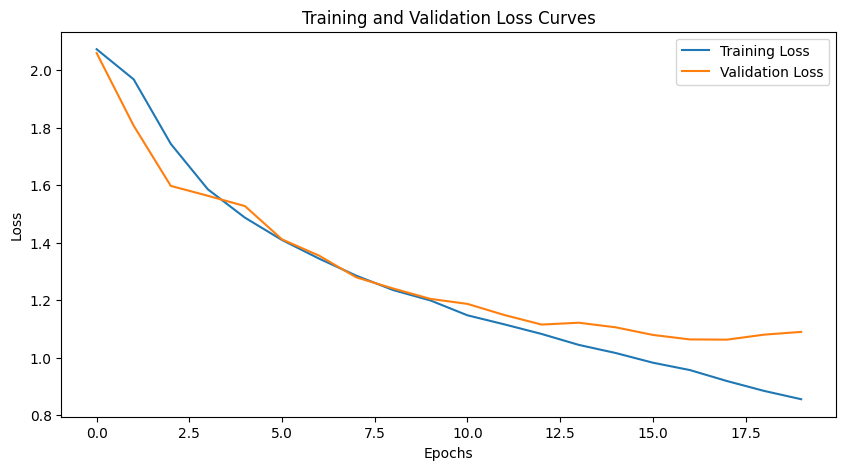

In [137]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Example usage
train_losses = logger.logs['train_loss']
val_losses = logger.logs['test_loss']
plot_loss_curves(train_losses, val_losses)

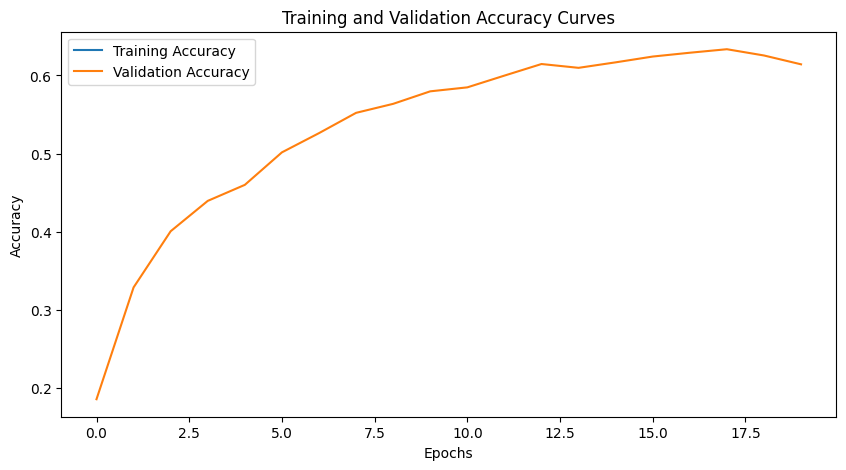

In [138]:
def plot_accuracy_curves(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Example usage
train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['test_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

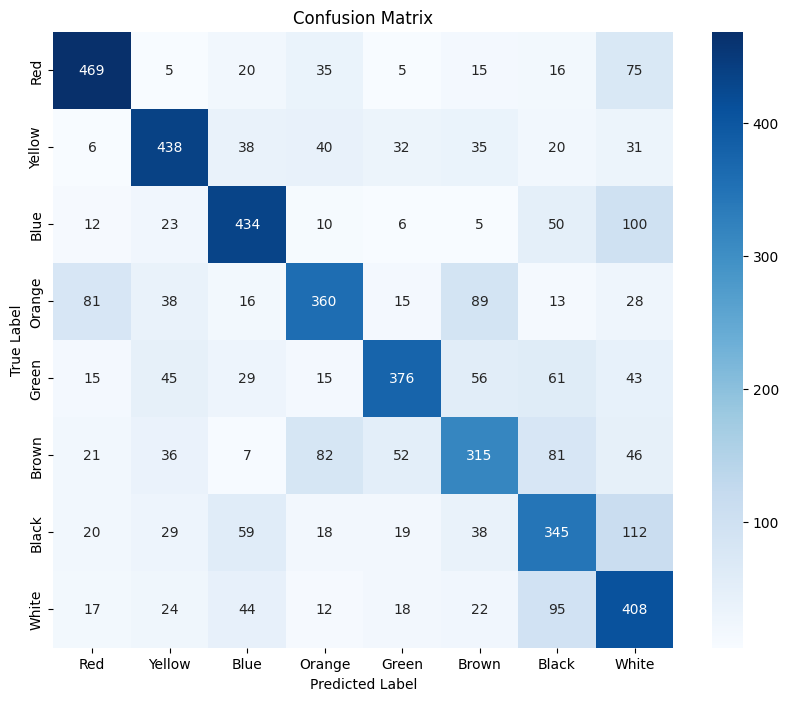

In [139]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure labels are defined
labels = ["Red", "Yellow", "Blue", "Orange", "Green", "Brown", "Black", "White"]

# Example usage (assuming y_test contains true labels)
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, labels)

## Modelo 2 - CIELAB

In [140]:
# Save Model
Model_Path = '/content/models/alternative_model_B'
logger = Logger(Model_Path, "Exp2B", 1)

In [141]:
model = ColorModel2()
model.cuda()
opt = torch.optim.SGD(model.parameters(), momentum=0.9, lr = 0.001 )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=20,min_lr=1e-08,factor=0.1,verbose=True)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [142]:
epochs = 100
from  tqdm import tqdm
from sklearn.metrics import accuracy_score
for epoch in range(epochs):
    with tqdm(train_data_loader, unit="batch") as tepoch:
        model.train()
        running_loss = 0
        batch_ = 0
        for X,y in tepoch:
            tepoch.set_description(f"Train | Epoch {epoch}")
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model.forward(X)
            loss_value = loss_fn(pred, y)
            loss_value.backward()
            opt.step()
            opt.zero_grad()
            batch_ +=1
            running_loss += loss_value.item()
            tepoch.set_postfix(loss = running_loss/batch_)
        logger.log('train_loss', running_loss/batch_)
    with torch.no_grad():
        model.eval()
        with tqdm(test_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Test | Epoch {epoch}")
            correct = 0
            n_batch = 0
            running_loss = 0
            for X,y in tepoch:
                X, y = X.to('cuda') , y.to('cuda')
                pred = model.forward(X)
                pred_class = pred.argmax(dim = 1)
                loss_value = loss_fn(pred,y)
                running_loss += loss_value.item()
                curr_correct = (pred_class == y).float().sum().item()
                correct += curr_correct
                n_batch +=1
                tepoch.set_postfix(loss = running_loss/n_batch , accuracy = correct / (n_batch*32) *100)
            logger.log('test_loss', running_loss/n_batch)
            logger.log('test_acc', correct/(n_batch*32))
    logger.checkpoint(model)

Train | Epoch 0: 100%|██████████| 240/240 [00:03<00:00, 64.75batch/s, loss=2.08]
Test | Epoch 0: 100%|██████████| 160/160 [00:02<00:00, 79.35batch/s, accuracy=12.5, loss=2.08]


Saving Model...


Train | Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 62.80batch/s, loss=2.08]
Test | Epoch 1: 100%|██████████| 160/160 [00:02<00:00, 74.73batch/s, accuracy=12.5, loss=2.08]


Saving Model...


Train | Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 61.35batch/s, loss=2.08]
Test | Epoch 2: 100%|██████████| 160/160 [00:02<00:00, 76.88batch/s, accuracy=12.5, loss=2.08]


Saving Model...


Train | Epoch 3: 100%|██████████| 240/240 [00:03<00:00, 63.45batch/s, loss=2.08]
Test | Epoch 3: 100%|██████████| 160/160 [00:02<00:00, 77.67batch/s, accuracy=12.5, loss=2.08]


Saving Model...


Train | Epoch 4: 100%|██████████| 240/240 [00:03<00:00, 63.99batch/s, loss=2.08]
Test | Epoch 4: 100%|██████████| 160/160 [00:01<00:00, 80.45batch/s, accuracy=13.7, loss=2.08]


Saving Model...


Train | Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 64.90batch/s, loss=2.08]
Test | Epoch 5: 100%|██████████| 160/160 [00:02<00:00, 77.79batch/s, accuracy=14.3, loss=2.08]


Saving Model...


Train | Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 63.53batch/s, loss=2.08]
Test | Epoch 6: 100%|██████████| 160/160 [00:02<00:00, 78.12batch/s, accuracy=16, loss=2.08]


Saving Model...


Train | Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 63.09batch/s, loss=2.08]
Test | Epoch 7: 100%|██████████| 160/160 [00:02<00:00, 78.86batch/s, accuracy=19.5, loss=2.08]


Saving Model...


Train | Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 64.92batch/s, loss=2.08]
Test | Epoch 8: 100%|██████████| 160/160 [00:01<00:00, 80.71batch/s, accuracy=22.5, loss=2.08]


Saving Model...


Train | Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 65.16batch/s, loss=2.08]
Test | Epoch 9: 100%|██████████| 160/160 [00:02<00:00, 78.71batch/s, accuracy=23.8, loss=2.08]


Saving Model...


Train | Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 64.93batch/s, loss=2.08]
Test | Epoch 10: 100%|██████████| 160/160 [00:02<00:00, 78.63batch/s, accuracy=24.7, loss=2.07]


Saving Model...


Train | Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 64.67batch/s, loss=2.07]
Test | Epoch 11: 100%|██████████| 160/160 [00:02<00:00, 78.30batch/s, accuracy=25, loss=2.07]


Saving Model...


Train | Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 62.99batch/s, loss=2.07]
Test | Epoch 12: 100%|██████████| 160/160 [00:02<00:00, 79.51batch/s, accuracy=25, loss=2.07]


Saving Model...


Train | Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 64.11batch/s, loss=2.06]
Test | Epoch 13: 100%|██████████| 160/160 [00:02<00:00, 79.04batch/s, accuracy=24.9, loss=2.06]


Saving Model...


Train | Epoch 14: 100%|██████████| 240/240 [00:03<00:00, 65.25batch/s, loss=2.05]
Test | Epoch 14: 100%|██████████| 160/160 [00:02<00:00, 79.97batch/s, accuracy=24.5, loss=2.03]


Saving Model...


Train | Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 65.30batch/s, loss=1.98]
Test | Epoch 15: 100%|██████████| 160/160 [00:02<00:00, 79.45batch/s, accuracy=25.2, loss=1.94]


Saving Model...


Train | Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 64.87batch/s, loss=1.88]
Test | Epoch 16: 100%|██████████| 160/160 [00:02<00:00, 79.42batch/s, accuracy=28.6, loss=1.84]


Saving Model...


Train | Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 65.20batch/s, loss=1.82]
Test | Epoch 17: 100%|██████████| 160/160 [00:01<00:00, 80.17batch/s, accuracy=30.2, loss=1.8]


Saving Model...


Train | Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 64.95batch/s, loss=1.77]
Test | Epoch 18: 100%|██████████| 160/160 [00:02<00:00, 78.26batch/s, accuracy=32.1, loss=1.76]


Saving Model...


Train | Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 64.47batch/s, loss=1.72]
Test | Epoch 19: 100%|██████████| 160/160 [00:02<00:00, 77.43batch/s, accuracy=33.9, loss=1.72]


Saving Model...


Train | Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 64.48batch/s, loss=1.69]
Test | Epoch 20: 100%|██████████| 160/160 [00:01<00:00, 80.86batch/s, accuracy=35.8, loss=1.69]


Saving Model...


Train | Epoch 21: 100%|██████████| 240/240 [00:03<00:00, 64.49batch/s, loss=1.66]
Test | Epoch 21: 100%|██████████| 160/160 [00:02<00:00, 76.69batch/s, accuracy=36.7, loss=1.67]


Saving Model...


Train | Epoch 22: 100%|██████████| 240/240 [00:03<00:00, 62.89batch/s, loss=1.63]
Test | Epoch 22: 100%|██████████| 160/160 [00:02<00:00, 79.87batch/s, accuracy=36.5, loss=1.67]


Saving Model...


Train | Epoch 23: 100%|██████████| 240/240 [00:03<00:00, 62.28batch/s, loss=1.59]
Test | Epoch 23: 100%|██████████| 160/160 [00:02<00:00, 77.90batch/s, accuracy=38.7, loss=1.63]


Saving Model...


Train | Epoch 24: 100%|██████████| 240/240 [00:03<00:00, 60.96batch/s, loss=1.54]
Test | Epoch 24: 100%|██████████| 160/160 [00:02<00:00, 78.34batch/s, accuracy=42.7, loss=1.57]


Saving Model...


Train | Epoch 25: 100%|██████████| 240/240 [00:03<00:00, 63.25batch/s, loss=1.5]
Test | Epoch 25: 100%|██████████| 160/160 [00:01<00:00, 80.33batch/s, accuracy=43.6, loss=1.54]


Saving Model...


Train | Epoch 26: 100%|██████████| 240/240 [00:03<00:00, 64.32batch/s, loss=1.45]
Test | Epoch 26: 100%|██████████| 160/160 [00:01<00:00, 82.30batch/s, accuracy=44.1, loss=1.53]


Saving Model...


Train | Epoch 27: 100%|██████████| 240/240 [00:03<00:00, 64.74batch/s, loss=1.42]
Test | Epoch 27: 100%|██████████| 160/160 [00:02<00:00, 79.07batch/s, accuracy=46.5, loss=1.48]


Saving Model...


Train | Epoch 28: 100%|██████████| 240/240 [00:03<00:00, 64.95batch/s, loss=1.39]
Test | Epoch 28: 100%|██████████| 160/160 [00:01<00:00, 81.74batch/s, accuracy=48.4, loss=1.44]


Saving Model...


Train | Epoch 29: 100%|██████████| 240/240 [00:03<00:00, 65.00batch/s, loss=1.36]
Test | Epoch 29: 100%|██████████| 160/160 [00:02<00:00, 79.48batch/s, accuracy=49.4, loss=1.4]


Saving Model...


Train | Epoch 30: 100%|██████████| 240/240 [00:03<00:00, 63.77batch/s, loss=1.33]
Test | Epoch 30: 100%|██████████| 160/160 [00:02<00:00, 78.95batch/s, accuracy=50, loss=1.38]


Saving Model...


Train | Epoch 31: 100%|██████████| 240/240 [00:03<00:00, 64.87batch/s, loss=1.31]
Test | Epoch 31: 100%|██████████| 160/160 [00:01<00:00, 81.12batch/s, accuracy=50.6, loss=1.36]


Saving Model...


Train | Epoch 32: 100%|██████████| 240/240 [00:03<00:00, 64.86batch/s, loss=1.29]
Test | Epoch 32: 100%|██████████| 160/160 [00:02<00:00, 79.76batch/s, accuracy=51.3, loss=1.35]


Saving Model...


Train | Epoch 33: 100%|██████████| 240/240 [00:03<00:00, 64.04batch/s, loss=1.28]
Test | Epoch 33: 100%|██████████| 160/160 [00:01<00:00, 80.61batch/s, accuracy=52, loss=1.34]


Saving Model...


Train | Epoch 34: 100%|██████████| 240/240 [00:03<00:00, 63.69batch/s, loss=1.26]
Test | Epoch 34: 100%|██████████| 160/160 [00:01<00:00, 81.96batch/s, accuracy=52.6, loss=1.32]


Saving Model...


Train | Epoch 35: 100%|██████████| 240/240 [00:03<00:00, 65.19batch/s, loss=1.25]
Test | Epoch 35: 100%|██████████| 160/160 [00:02<00:00, 79.17batch/s, accuracy=53.1, loss=1.32]


Saving Model...


Train | Epoch 36: 100%|██████████| 240/240 [00:03<00:00, 63.03batch/s, loss=1.24]
Test | Epoch 36: 100%|██████████| 160/160 [00:02<00:00, 78.93batch/s, accuracy=53.6, loss=1.3]


Saving Model...


Train | Epoch 37: 100%|██████████| 240/240 [00:03<00:00, 63.92batch/s, loss=1.22]
Test | Epoch 37: 100%|██████████| 160/160 [00:01<00:00, 80.10batch/s, accuracy=53.6, loss=1.3]


Saving Model...


Train | Epoch 38: 100%|██████████| 240/240 [00:03<00:00, 63.20batch/s, loss=1.21]
Test | Epoch 38: 100%|██████████| 160/160 [00:02<00:00, 78.30batch/s, accuracy=53.8, loss=1.29]


Saving Model...


Train | Epoch 39: 100%|██████████| 240/240 [00:03<00:00, 63.04batch/s, loss=1.2]
Test | Epoch 39: 100%|██████████| 160/160 [00:02<00:00, 79.39batch/s, accuracy=54.5, loss=1.28]


Saving Model...


Train | Epoch 40: 100%|██████████| 240/240 [00:03<00:00, 63.32batch/s, loss=1.18]
Test | Epoch 40: 100%|██████████| 160/160 [00:02<00:00, 79.10batch/s, accuracy=54.9, loss=1.27]


Saving Model...


Train | Epoch 41: 100%|██████████| 240/240 [00:03<00:00, 63.44batch/s, loss=1.17]
Test | Epoch 41: 100%|██████████| 160/160 [00:02<00:00, 79.25batch/s, accuracy=55.3, loss=1.26]


Saving Model...


Train | Epoch 42: 100%|██████████| 240/240 [00:03<00:00, 60.51batch/s, loss=1.16]
Test | Epoch 42: 100%|██████████| 160/160 [00:01<00:00, 80.09batch/s, accuracy=55.5, loss=1.25]


Saving Model...


Train | Epoch 43: 100%|██████████| 240/240 [00:03<00:00, 64.28batch/s, loss=1.15]
Test | Epoch 43: 100%|██████████| 160/160 [00:02<00:00, 76.99batch/s, accuracy=55.9, loss=1.24]


Saving Model...


Train | Epoch 44: 100%|██████████| 240/240 [00:03<00:00, 63.94batch/s, loss=1.14]
Test | Epoch 44: 100%|██████████| 160/160 [00:01<00:00, 81.12batch/s, accuracy=56.2, loss=1.24]


Saving Model...


Train | Epoch 45: 100%|██████████| 240/240 [00:03<00:00, 64.24batch/s, loss=1.12]
Test | Epoch 45: 100%|██████████| 160/160 [00:02<00:00, 78.24batch/s, accuracy=56.7, loss=1.23]


Saving Model...


Train | Epoch 46: 100%|██████████| 240/240 [00:03<00:00, 60.65batch/s, loss=1.11]
Test | Epoch 46: 100%|██████████| 160/160 [00:01<00:00, 80.06batch/s, accuracy=57, loss=1.22]


Saving Model...


Train | Epoch 47: 100%|██████████| 240/240 [00:03<00:00, 64.09batch/s, loss=1.1]
Test | Epoch 47: 100%|██████████| 160/160 [00:01<00:00, 80.12batch/s, accuracy=57.1, loss=1.22]


Saving Model...


Train | Epoch 48: 100%|██████████| 240/240 [00:03<00:00, 63.47batch/s, loss=1.09]
Test | Epoch 48: 100%|██████████| 160/160 [00:01<00:00, 80.13batch/s, accuracy=57.1, loss=1.21]


Saving Model...


Train | Epoch 49: 100%|██████████| 240/240 [00:03<00:00, 64.44batch/s, loss=1.08]
Test | Epoch 49: 100%|██████████| 160/160 [00:01<00:00, 80.43batch/s, accuracy=57.5, loss=1.21]


Saving Model...


Train | Epoch 50: 100%|██████████| 240/240 [00:03<00:00, 62.69batch/s, loss=1.07]
Test | Epoch 50: 100%|██████████| 160/160 [00:02<00:00, 79.74batch/s, accuracy=57.9, loss=1.2]


Saving Model...


Train | Epoch 51: 100%|██████████| 240/240 [00:03<00:00, 64.83batch/s, loss=1.06]
Test | Epoch 51: 100%|██████████| 160/160 [00:01<00:00, 80.57batch/s, accuracy=58.1, loss=1.2]


Saving Model...


Train | Epoch 52: 100%|██████████| 240/240 [00:03<00:00, 62.66batch/s, loss=1.05]
Test | Epoch 52: 100%|██████████| 160/160 [00:01<00:00, 80.76batch/s, accuracy=58.1, loss=1.2]


Saving Model...


Train | Epoch 53: 100%|██████████| 240/240 [00:03<00:00, 65.72batch/s, loss=1.04]
Test | Epoch 53: 100%|██████████| 160/160 [00:02<00:00, 78.56batch/s, accuracy=58.1, loss=1.2]


Saving Model...


Train | Epoch 54: 100%|██████████| 240/240 [00:03<00:00, 62.28batch/s, loss=1.03]
Test | Epoch 54: 100%|██████████| 160/160 [00:02<00:00, 77.73batch/s, accuracy=58.4, loss=1.19]


Saving Model...


Train | Epoch 55: 100%|██████████| 240/240 [00:03<00:00, 64.52batch/s, loss=1.02]
Test | Epoch 55: 100%|██████████| 160/160 [00:01<00:00, 81.19batch/s, accuracy=58.5, loss=1.19]


Saving Model...


Train | Epoch 56: 100%|██████████| 240/240 [00:03<00:00, 62.41batch/s, loss=1]
Test | Epoch 56: 100%|██████████| 160/160 [00:01<00:00, 80.39batch/s, accuracy=58.5, loss=1.19]


Saving Model...


Train | Epoch 57: 100%|██████████| 240/240 [00:03<00:00, 64.33batch/s, loss=0.993]
Test | Epoch 57: 100%|██████████| 160/160 [00:01<00:00, 80.73batch/s, accuracy=58.5, loss=1.19]


Saving Model...


Train | Epoch 58: 100%|██████████| 240/240 [00:03<00:00, 61.42batch/s, loss=0.982]
Test | Epoch 58: 100%|██████████| 160/160 [00:01<00:00, 80.02batch/s, accuracy=58.5, loss=1.19]


Saving Model...


Train | Epoch 59: 100%|██████████| 240/240 [00:03<00:00, 64.08batch/s, loss=0.971]
Test | Epoch 59: 100%|██████████| 160/160 [00:02<00:00, 79.48batch/s, accuracy=58.8, loss=1.19]


Saving Model...


Train | Epoch 60: 100%|██████████| 240/240 [00:03<00:00, 63.05batch/s, loss=0.958]
Test | Epoch 60: 100%|██████████| 160/160 [00:02<00:00, 79.15batch/s, accuracy=58.8, loss=1.19]


Saving Model...


Train | Epoch 61: 100%|██████████| 240/240 [00:03<00:00, 63.71batch/s, loss=0.947]
Test | Epoch 61: 100%|██████████| 160/160 [00:01<00:00, 80.32batch/s, accuracy=59.2, loss=1.19]


Saving Model...


Train | Epoch 62: 100%|██████████| 240/240 [00:03<00:00, 64.20batch/s, loss=0.934]
Test | Epoch 62: 100%|██████████| 160/160 [00:02<00:00, 79.26batch/s, accuracy=59.1, loss=1.19]


Saving Model...


Train | Epoch 63: 100%|██████████| 240/240 [00:03<00:00, 63.22batch/s, loss=0.923]
Test | Epoch 63: 100%|██████████| 160/160 [00:01<00:00, 81.11batch/s, accuracy=59.1, loss=1.19]


Saving Model...


Train | Epoch 64: 100%|██████████| 240/240 [00:03<00:00, 63.17batch/s, loss=0.909]
Test | Epoch 64: 100%|██████████| 160/160 [00:02<00:00, 77.75batch/s, accuracy=59.1, loss=1.19]


Saving Model...


Train | Epoch 65: 100%|██████████| 240/240 [00:03<00:00, 64.44batch/s, loss=0.897]
Test | Epoch 65: 100%|██████████| 160/160 [00:02<00:00, 79.34batch/s, accuracy=59.2, loss=1.2]


Saving Model...


Train | Epoch 66: 100%|██████████| 240/240 [00:03<00:00, 62.21batch/s, loss=0.883]
Test | Epoch 66: 100%|██████████| 160/160 [00:02<00:00, 79.21batch/s, accuracy=59.1, loss=1.2]


Saving Model...


Train | Epoch 67: 100%|██████████| 240/240 [00:03<00:00, 64.78batch/s, loss=0.869]
Test | Epoch 67: 100%|██████████| 160/160 [00:01<00:00, 80.03batch/s, accuracy=59.1, loss=1.21]


Saving Model...


Train | Epoch 68: 100%|██████████| 240/240 [00:03<00:00, 63.01batch/s, loss=0.855]
Test | Epoch 68: 100%|██████████| 160/160 [00:01<00:00, 81.41batch/s, accuracy=59.2, loss=1.21]


Saving Model...


Train | Epoch 69: 100%|██████████| 240/240 [00:03<00:00, 64.74batch/s, loss=0.84]
Test | Epoch 69: 100%|██████████| 160/160 [00:01<00:00, 81.28batch/s, accuracy=59.3, loss=1.21]


Saving Model...


Train | Epoch 70: 100%|██████████| 240/240 [00:03<00:00, 63.34batch/s, loss=0.825]
Test | Epoch 70: 100%|██████████| 160/160 [00:01<00:00, 80.94batch/s, accuracy=59.6, loss=1.22]


Saving Model...


Train | Epoch 71: 100%|██████████| 240/240 [00:03<00:00, 62.28batch/s, loss=0.807]
Test | Epoch 71: 100%|██████████| 160/160 [00:02<00:00, 77.82batch/s, accuracy=59.4, loss=1.23]


Saving Model...


Train | Epoch 72: 100%|██████████| 240/240 [00:03<00:00, 62.99batch/s, loss=0.79]
Test | Epoch 72: 100%|██████████| 160/160 [00:01<00:00, 80.60batch/s, accuracy=59.4, loss=1.24]


Saving Model...


Train | Epoch 73: 100%|██████████| 240/240 [00:03<00:00, 62.94batch/s, loss=0.773]
Test | Epoch 73: 100%|██████████| 160/160 [00:01<00:00, 80.12batch/s, accuracy=59.2, loss=1.24]


Saving Model...


Train | Epoch 74: 100%|██████████| 240/240 [00:03<00:00, 62.62batch/s, loss=0.754]
Test | Epoch 74: 100%|██████████| 160/160 [00:02<00:00, 78.48batch/s, accuracy=58.9, loss=1.25]


Saving Model...


Train | Epoch 75: 100%|██████████| 240/240 [00:03<00:00, 63.13batch/s, loss=0.734]
Test | Epoch 75: 100%|██████████| 160/160 [00:02<00:00, 79.67batch/s, accuracy=58.4, loss=1.27]


Saving Model...


Train | Epoch 76: 100%|██████████| 240/240 [00:03<00:00, 62.32batch/s, loss=0.714]
Test | Epoch 76: 100%|██████████| 160/160 [00:02<00:00, 78.79batch/s, accuracy=58.3, loss=1.28]


Saving Model...


Train | Epoch 77: 100%|██████████| 240/240 [00:03<00:00, 63.24batch/s, loss=0.694]
Test | Epoch 77: 100%|██████████| 160/160 [00:02<00:00, 78.83batch/s, accuracy=57.9, loss=1.3]


Saving Model...


Train | Epoch 78: 100%|██████████| 240/240 [00:03<00:00, 63.35batch/s, loss=0.673]
Test | Epoch 78: 100%|██████████| 160/160 [00:01<00:00, 80.01batch/s, accuracy=57.9, loss=1.32]


Saving Model...


Train | Epoch 79: 100%|██████████| 240/240 [00:03<00:00, 64.27batch/s, loss=0.652]
Test | Epoch 79: 100%|██████████| 160/160 [00:01<00:00, 80.49batch/s, accuracy=57.8, loss=1.34]


Saving Model...


Train | Epoch 80: 100%|██████████| 240/240 [00:03<00:00, 62.56batch/s, loss=0.628]
Test | Epoch 80: 100%|██████████| 160/160 [00:02<00:00, 79.86batch/s, accuracy=57.5, loss=1.37]


Saving Model...


Train | Epoch 81: 100%|██████████| 240/240 [00:03<00:00, 64.25batch/s, loss=0.605]
Test | Epoch 81: 100%|██████████| 160/160 [00:02<00:00, 79.54batch/s, accuracy=57.6, loss=1.4]


Saving Model...


Train | Epoch 82: 100%|██████████| 240/240 [00:03<00:00, 63.97batch/s, loss=0.581]
Test | Epoch 82: 100%|██████████| 160/160 [00:01<00:00, 80.51batch/s, accuracy=57.3, loss=1.43]


Saving Model...


Train | Epoch 83: 100%|██████████| 240/240 [00:03<00:00, 65.23batch/s, loss=0.557]
Test | Epoch 83: 100%|██████████| 160/160 [00:01<00:00, 80.45batch/s, accuracy=57.2, loss=1.45]


Saving Model...


Train | Epoch 84: 100%|██████████| 240/240 [00:03<00:00, 63.64batch/s, loss=0.534]
Test | Epoch 84: 100%|██████████| 160/160 [00:02<00:00, 79.10batch/s, accuracy=56.6, loss=1.52]


Saving Model...


Train | Epoch 85: 100%|██████████| 240/240 [00:03<00:00, 64.81batch/s, loss=0.51]
Test | Epoch 85: 100%|██████████| 160/160 [00:02<00:00, 79.53batch/s, accuracy=56.5, loss=1.55]


Saving Model...


Train | Epoch 86: 100%|██████████| 240/240 [00:03<00:00, 63.99batch/s, loss=0.484]
Test | Epoch 86: 100%|██████████| 160/160 [00:01<00:00, 80.43batch/s, accuracy=56.4, loss=1.62]


Saving Model...


Train | Epoch 87: 100%|██████████| 240/240 [00:03<00:00, 65.26batch/s, loss=0.459]
Test | Epoch 87: 100%|██████████| 160/160 [00:01<00:00, 80.87batch/s, accuracy=55.5, loss=1.7]


Saving Model...


Train | Epoch 88: 100%|██████████| 240/240 [00:03<00:00, 62.11batch/s, loss=0.439]
Test | Epoch 88: 100%|██████████| 160/160 [00:02<00:00, 79.48batch/s, accuracy=54, loss=1.83]


Saving Model...


Train | Epoch 89: 100%|██████████| 240/240 [00:03<00:00, 63.95batch/s, loss=0.427]
Test | Epoch 89: 100%|██████████| 160/160 [00:01<00:00, 80.27batch/s, accuracy=54.7, loss=1.86]


Saving Model...


Train | Epoch 90: 100%|██████████| 240/240 [00:03<00:00, 62.75batch/s, loss=0.445]
Test | Epoch 90: 100%|██████████| 160/160 [00:02<00:00, 78.49batch/s, accuracy=53.8, loss=1.9]


Saving Model...


Train | Epoch 91: 100%|██████████| 240/240 [00:03<00:00, 64.72batch/s, loss=0.486]
Test | Epoch 91: 100%|██████████| 160/160 [00:01<00:00, 80.52batch/s, accuracy=54.3, loss=1.79]


Saving Model...


Train | Epoch 92: 100%|██████████| 240/240 [00:03<00:00, 62.88batch/s, loss=0.512]
Test | Epoch 92: 100%|██████████| 160/160 [00:02<00:00, 79.28batch/s, accuracy=55.4, loss=1.78]


Saving Model...


Train | Epoch 93: 100%|██████████| 240/240 [00:03<00:00, 62.57batch/s, loss=0.481]
Test | Epoch 93: 100%|██████████| 160/160 [00:02<00:00, 79.30batch/s, accuracy=55.2, loss=1.8]


Saving Model...


Train | Epoch 94: 100%|██████████| 240/240 [00:03<00:00, 62.72batch/s, loss=0.449]
Test | Epoch 94: 100%|██████████| 160/160 [00:02<00:00, 78.18batch/s, accuracy=56.7, loss=1.74]


Saving Model...


Train | Epoch 95: 100%|██████████| 240/240 [00:03<00:00, 64.79batch/s, loss=0.431]
Test | Epoch 95: 100%|██████████| 160/160 [00:01<00:00, 80.12batch/s, accuracy=56.5, loss=1.78]


Saving Model...


Train | Epoch 96: 100%|██████████| 240/240 [00:03<00:00, 63.66batch/s, loss=0.431]
Test | Epoch 96: 100%|██████████| 160/160 [00:01<00:00, 81.10batch/s, accuracy=56.9, loss=1.74]


Saving Model...


Train | Epoch 97: 100%|██████████| 240/240 [00:03<00:00, 64.69batch/s, loss=0.402]
Test | Epoch 97: 100%|██████████| 160/160 [00:02<00:00, 78.83batch/s, accuracy=56.8, loss=1.78]


Saving Model...


Train | Epoch 98: 100%|██████████| 240/240 [00:03<00:00, 63.04batch/s, loss=0.383]
Test | Epoch 98: 100%|██████████| 160/160 [00:01<00:00, 80.62batch/s, accuracy=56.2, loss=1.8]


Saving Model...


Train | Epoch 99: 100%|██████████| 240/240 [00:03<00:00, 64.41batch/s, loss=0.365]
Test | Epoch 99: 100%|██████████| 160/160 [00:01<00:00, 80.81batch/s, accuracy=53.8, loss=1.99]


Saving Model...


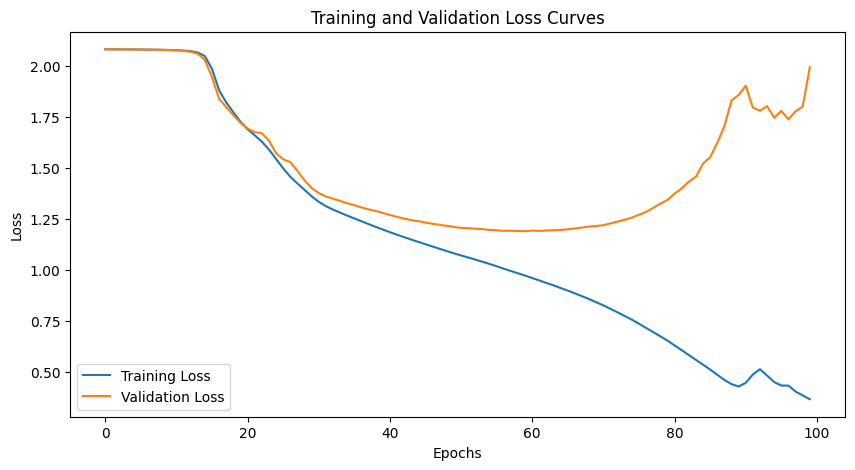

In [143]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

# Example usage
train_losses = logger.logs['train_loss']
val_losses = logger.logs['test_loss']
plot_loss_curves(train_losses, val_losses)

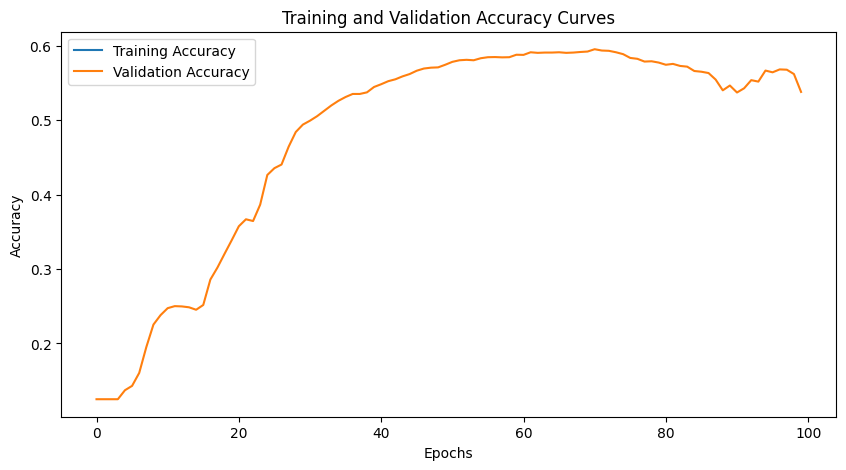

In [144]:
def plot_accuracy_curves(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

# Example usage
train_accuracies = [acc for acc in logger.logs['train_acc']]
val_accuracies = [acc for acc in logger.logs['test_acc']]
plot_accuracy_curves(train_accuracies, val_accuracies)

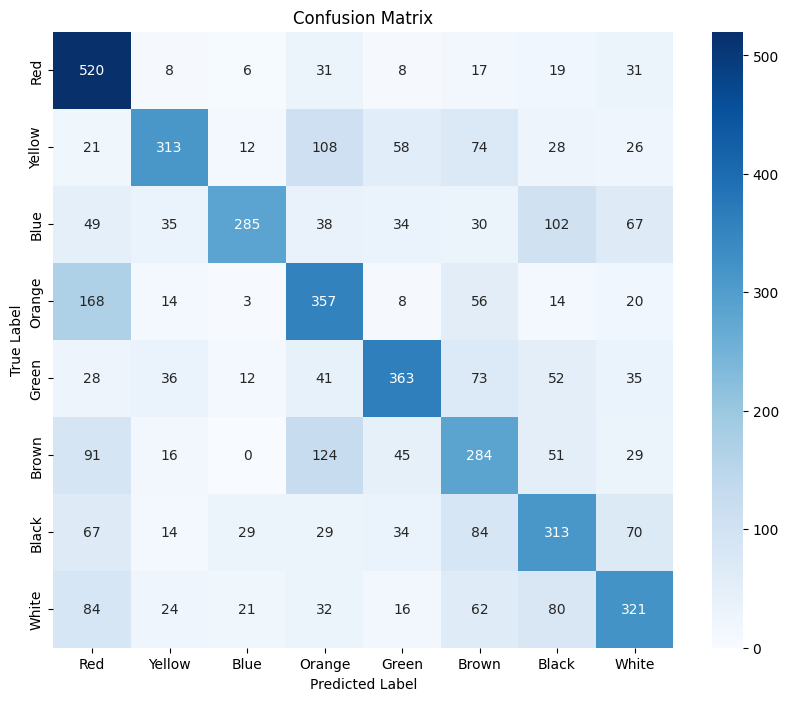

In [145]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure labels are defined
labels = ["Red", "Yellow", "Blue", "Orange", "Green", "Brown", "Black", "White"]

# Example usage (assuming y_test contains true labels)
y_true = y_test  # Directly use y_test
y_pred = []

with torch.no_grad():
    model.eval()
    for X, y in test_data_loader:
        X, y = X.to('cuda'), y.to('cuda')
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, labels)

#4 - Selección de Modelo Final

#5 - Métricas de Rendimiento del Modelo Final

**Training and Validation Loss Curve:**

**Training and Validation Accuracy Curve:**

#6 - Conclusiones

**Conclusiones**

#7 - Referencias

1. Smits, Thomas & Wevers, Melvin. (2021). The agency of computer vision models as optical instruments. Visual Communication. 21. 147035722199209. 10.1177/1470357221992097.

2. Top 10 Datasets for Computer Vision · Syntric AI. (2022). Retrieved from https://www.syntric.ai/post/unlocking-computer-vision-the-10-best-datasets

3. Common Objects in Context. (n.d.). Retrieved from https://cocodataset.org/#home

4. Meel, V. (2024). What is the COCO Dataset? What you need to know in 2024. Retrieved from https://viso.ai/computer-vision/coco-dataset/

5. Maitlo, N., Noonari, N., Ghanghro, S. A., Duraisamy, S., & Ahmed, F. (2024). Color Recognition in Challenging Lighting Environments: CNN Approach. ArXiv. /abs/2402.04762

6. De, K., & Pedersen, M. (2021). Impact of Colour on Robustness of Deep Neural Networks. 2021 IEEE/CVF International Conference on Computer Vision Workshops (ICCVW), 21–30. https://doi.org/10.1109/ICCVW54120.2021.00009

7. FiftyOne by Voxel 51. (n.d.). Retrieved from https://docs.voxel51.com/

8. COCO Dataset Integration in Fifty One. (n.d.). Retrieved from https://docs.voxel51.com/integrations/coco.html?highlight=coco

9. Hofesmann, E. (2022). The COCO Dataset: Best Practices for Downloading, Visualization, and Evaluation. Retrieved from https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

10. Clustering Images with Embeddings. (n.d.). Retrieved from https://docs.voxel51.com/tutorials/clustering.html

11. Gallagher, J. (2024). Color and Product Type Inspection with Computer Vision. Retrieved from https://blog.roboflow.com/how-to-analyze-product-color/

12. Lin, T.-Y., Maire, M., Belongie, S., Bourdev, L., Girshick, R., Hays, J., … Dollár, P. (2015). Microsoft COCO: Common Objects in Context. Retrieved from https://arxiv.org/abs/1405.0312

13. Rachmadi, R. F., & Purnama, I. K. E. (2018). Vehicle Color Recognition using Convolutional Neural Network. Retrieved from https://arxiv.org/abs/1510.07391

14. Hofesmann, E. (2021). How to work with object detection datasets in COCO format. Retrieved from https://towardsdatascience.com/how-to-work-with-object-detection-datasets-in-coco-format-9bf4fb5848a4

15. Prepare COCO datasets¶. (n.d.). Retrieved from https://cv.gluon.ai/build/examples_datasets/mscoco.html

16. skimage.color#. (n.d.). Retrieved from https://scikit-image.org/docs/dev/api/skimage.color.html

17. Colors Tutorial. W3 Schools. (N.d.). Retrieved from https://www.w3schools.com/colors/colors_wheels.asp#:~:text=The%203%20primary%20colors%20are,Orange%2C%20Green%2C%20and%20Purple.&text=Blue%20and%20Red%20%3D%20Purple.